# SURFER v3.0
---
__Author__ : Couplet Victor 

__Content__ : Extended version of SURFER v2.0 based on Monteiro (2022).

Used and modified by Amaury Laridon for his Master's Thesis.


## What's new in the version v3.0 ? 

- Tipping cascade module 
    - Interacting tipping elements connected to the temperature anomalies of the climate model
    - Contribution of the interacting tipping element to the radiative forcing in the climate model
    - Tipping elements modelized 
        - AMOC
        - GIS
        - WAIS
        - EASB
        - EAIS
        - AWSI
        - AMAZ
        - PERM
- Ugraded version of the carbon cycle model
    - Upgraded version of the ocean's model
        - Addition of an intermediate layer of the ocean
        - Addition of a sediments layer
- Upgraded version of the climate model
    - Addition of an intermediate layer of the ocean
- Addition of a $CH_4$ model with emissions and concentrations  


---


## Library

In [4]:
import numpy as np

from math import floor,log10

from scipy.integrate import solve_ivp, odeint
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import linalg
from scipy.sparse import diags

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

import matplotlib.gridspec as gridspec

%matplotlib nbagg

## Model SURFER v3.0

In [5]:
mA=1.727*10**20
mO=7.8*10**22
carbon_molar_mass=12*10**-3
water_molar_mass=18*10**-3
CO23_sat = 68.27

fco2 = 3.9
beta = 1.1143
gamma = 0.8357
cvol = 0.13

tau_ch4 = 9.5

Sglpot = 0.5
Sglxi = 2
taugl = 200

def SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,**kwargs):
    
    if kwargs['ktemp'] == True :
        ktemp = 1
    else : ktemp = 0
        
    if kwargs['sediments'] == True : 
        sed = 1
    else : sed = 0
        
    if kwargs['weathering'] == True : 
        weathering = 1
    else : weathering = 0
    
    def f(t,y) :
    
        K0U= k0(T_U+ktemp*y[9],S_U)
        K1U= k1(T_U+ktemp*y[9],S_U)
        K2U= k2(T_U+ktemp*y[9],S_U)
        BU = b(y[2],y[5],K1U,K2U)

        K1D = k1(T_D+ktemp*y[11],S_D)
        K2D = k2(T_D+ktemp*y[11],S_D)
        CO32_D = CO32D(y[4],y[7],K1D,K2D)

        co2_em_landuse = co2_landuse(t)
        co2_em_fossil = co2_fossil(t)
        ch4_em_landuse = ch4_landuse(t) 
        ch4_em_fossil = ch4_fossil(t) 
        
        E = co2_em_landuse + co2_em_fossil
        F_volcanism = V*sed
        F_CaCO3 = weathering*F_CaCO3_pi*(1+0.049*y[9])+(1-weathering)*F_CaCO3_pi
        F_CaSiO3 = weathering*F_CaSiO3_pi*np.exp(0.09*y[9])+(1-weathering)*F_CaSiO3_pi
        F_weathering = sed*((1-X)*F_CaCO3+(2-X)*F_CaSiO3)
        F_river = sed*((2-X)*(F_CaCO3+F_CaSiO3))+F_LR
        F_alk_river = sed*(2*(F_CaCO3+F_CaSiO3))
        
        if kwargs['atmtoland_flux'] == 'old' : 
            F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/y[0])-(y[1]-y[13])) + F_LR
        else : F_AL = K_AL*(beta_L*(y[0]-MA_pi)/np.exp(k_al_exp*beta*np.log(2)/fco2*y[9])-(y[1]-y[13])) + F_LR
            
        F_AU = K_AU*(y[0]-mA/(WU*K0U)*BU*y[2])
        F_UI = K_UI*(y[2]-MU_pi/MI_pi*y[3])+sed*(F_CaCO3_pi + F_CaSiO3_pi)*y[3]/MI_pi
        F_ID = K_ID*(y[3]-MI_pi/MD_pi*y[4])+sed*(F_CaCO3_pi + F_CaSiO3_pi)*y[4]/MD_pi
        F_accumulation = sed*(acc(CO32_D,y[8]/2))
        F_burial = sed*(bur(CO32_D,y[8]/2))
        F_alk_UI = sed*(K_alk_UI*(y[5]-QU_pi/QI_pi*y[6]) +2*(F_CaCO3_pi + F_CaSiO3_pi)*y[6]/QI_pi)
        F_alk_ID = sed*(K_alk_ID*(y[6]-QI_pi/QD_pi*y[7]) +2*(F_CaCO3_pi + F_CaSiO3_pi)*y[7]/QD_pi)
        F_alk_accumulation = sed*(2*F_accumulation)
        
        if y[8] > 0 : 
            allow_acc = 1
        else :
            if F_accumulation > 0 :
                allow_acc = 1
            else :
                allow_acc = 0
                    
        COUPLING = S_moy@(1-y[15:].T)
        H = -y[15:]**3+A2*y[15:]**2+A1*y[15:]+C1*y[9]-d*COUPLING+C0
        MU = H*0
        
        for i in range(0,len(y0)-15) :
            if H[i]>0 : 
                if y[15+i]< 1 :
                    MU[i] = 1/TAUP[i]
                else :
                    MU[i] = 0
            else :
                if y[15+i]> 0.01 :
                    MU[i] = 1/TAUM[i]
                elif 0 < y[15+i]< 0.01 :
                    MU[i] = 0
                else : MU[i] = -1/TAUM[i]
                    
        ## add coupling for AMOC (need derivatives)
        
        H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
        
        if H[5]>0 : 
            if y[15+5]< 1:
                MU[5] = 1/TAUP[5]
            else : MU[5] = 0
        else :
            if y[15+5]> 0.01 :
                MU[5] = 1/TAUM[5]
            elif 0< y[15+5]<0.01 :
                MU[5] = 0
            else :
                MU[5] = -1/TAUM[5]
                
        co2_em_tps = cfeedback*CPOT@(MU*H)*-1
        ch4_em_tps = cfeedback*CH4POT@(MU*H)*-1
                
        dy = np.zeros(len(y0))
        
        dy[0] = F_volcanism + E + co2_em_tps - F_AU - F_AL - F_weathering + (y[12]-Mch4_pi)/tau_ch4

        dy[1] = F_AL - F_LR - co2_em_landuse - ch4_em_landuse - co2_em_tps

        dy[2] = F_AU - F_UI + F_river
        dy[3] = F_UI - F_ID
        dy[4] = F_ID - F_accumulation*allow_acc 

        dy[5] =  - F_alk_UI + F_alk_river
        dy[6] = F_alk_UI - F_alk_ID
        dy[7] = F_alk_ID - F_alk_accumulation*allow_acc

        dy[8] = (F_accumulation - F_burial)*allow_acc

        dy[9] = (fco2*np.log2(y[0]/MA_pi)+0.036*((y[12]/(mA*carbon_molar_mass)*10**21)**0.5-ch4_pi**0.5)-beta*y[9]+epsi*FMOD@(1-y[15:])-gamma*(y[9]-y[10]))/(cvol*hu)
        dy[10] = (gamma*(y[9]-y[10])-gamma*(y[10]-y[11]))/(cvol*hi)
        dy[11] = gamma*(y[10]-y[11])/(cvol*hd)

        dy[12] = (Mch4_pi-y[12])/tau_ch4 + ch4_em_landuse + ch4_em_fossil + ch4_em_tps
        dy[13] = -co2_em_landuse - co2_em_tps
        
        dy[14]  = (Sglpot*np.tanh(y[9]/Sglxi)-y[14])/taugl
        
        dy[15:] = MU*H
        
        return dy

    
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

    if kwargs['int_method'] == 'RK45' : 
        sol=solve_ivp(f, [t0,tend], y0,method= 'RK45',rtol=10**-6,t_eval=teval)
    else : sol=solve_ivp(f, [t0,tend], y0,method= 'LSODA',t_eval=teval, max_step = 10000)
   
    
    return sol

In [6]:
archer_p = np.genfromtxt('archer_param.csv', delimiter=',')
x1 = archer_p[:,0]
x2 = archer_p[:,1]
x3 = archer_p[:,2]

CO32_pi = 87
MS_pi = 1750
F_weathering_pi = 0.13


A_acc = np.column_stack((x1-CO32_pi,x2-MS_pi/2,(x1-CO32_pi)*(x2-MS_pi/2)))
b_acc = x3-F_weathering_pi
acc_coef  = np.linalg.lstsq(A_acc, b_acc,rcond=None)[0]

def acc(CO32,M_BL) :
    return F_weathering_pi + (acc_coef[0]*(CO32-CO32_pi)+ acc_coef[1]*(M_BL-MS_pi/2)+ acc_coef[2]*(CO32-CO32_pi)*(M_BL-MS_pi/2))/1

def bur(CO32,M_BL) :
    bur =0.13*M_BL/(MS_pi/2)
    return bur

FileNotFoundError: archer_param.csv not found.

## Forcing scenarios

In [ ]:
################################# other custom forcings #################################

cb = np.genfromtxt('carbon_budget.csv', delimiter=',')
np.nan_to_num(cb, copy=False, nan=0.0)

x = np.concatenate(([1750],cb[100:,0]),axis=0)
y = np.concatenate(([0.25],cb[100:,2]),axis=0)
landuse_emissions = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)
fossil_emissions = interpolate.interp1d(cb[:,0],cb[:,1]-cb[:,6],bounds_error= False, fill_value=0)

# E=np.loadtxt(r"/home/vcouplet/Desktop/THESE/Data/historic_emissions.txt")
# fossil_emissions =interpolate.interp1d(E[:,0],E[:,1],bounds_error= False, fill_value="extrapolate")
# landuse = np.genfromtxt('landuse.csv', delimiter=',')
# landuse_emissions = interpolate.interp1d(landuse[:,0],landuse[:,1],bounds_error= False,fill_value=(landuse[0,1],landuse[-1,1]))

def emissions(t,toemit,emitted,emitting):
    total = toemit + emitted
    a= -emitting/(toemit*emitted)
    F = (total*toemit*np.exp(a*total*t))/(toemit*np.exp(a*total*t)+emitted)
    E = -a*F*(total-F)
    return E

def forcingCO2(tswitch,toemit,**kwargs):
    
    t=np.linspace(0,2000,2001)
    time = np.linspace(1750,tswitch,tswitch-1750+1)
    hist_em = fossil_emissions(time)
    
    if kwargs['landuse'] == True : 
        hist_em = fossil_emissions(time)+landuse_emissions(time)

    emitting = hist_em[-1]
    emitted = np.sum(hist_em)
    
    if kwargs['mode'] == 'add' : 
        total_toemit = toemit+emitting/2 # emitting/2 is a correction factor to get integrals right
    else : total_toemit = toemit-emitted+emitting/2
    
    x = emissions(t,total_toemit,emitted,emitting) 
    em = np.concatenate([hist_em,x[1:]])       
    t_em = np.concatenate([time-tswitch,t[1:]])

    forcing = interpolate.interp1d(t_em+tswitch-kwargs['origin'],em,bounds_error= False, fill_value=0)

    return forcing

def zero_forcing(teval):
    return interpolate.interp1d(teval,teval*0,bounds_error= False, fill_value=0)

################################# SSP CO2 for this study #################################

co2_ssp_landuse = np.genfromtxt('co2_ssp_landuse.csv', delimiter=',')
co2_ssp_total = np.genfromtxt('co2_ssp_total.csv', delimiter=',')
ssp_time = co2_ssp_landuse[0,:]

## ssp1-2.6

ssp_1_26_landuse = co2_ssp_landuse[1,:]*12/44*10**-3

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2151,1)
hist_em =  landuse_emissions(yearsbefore)

long_ssp = ssp_1_26_landuse[-1] -ssp_1_26_landuse[-1]*(yearsafter-2100)/50 
x = np.concatenate((yearsbefore,ssp_time,yearsafter),axis=0)
y = np.concatenate((hist_em,ssp_1_26_landuse,long_ssp),axis=0)
ssp_126_landuse = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

ssp_1_26_fossil = co2_ssp_total[1,:]*12/44*10**-3-ssp_1_26_landuse

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2201,1)
hist_em =  fossil_emissions(yearsbefore)

long_ssp = ssp_1_26_fossil[-1] -ssp_1_26_fossil[-1]*(yearsafter-2100)/100 
x = np.concatenate((yearsbefore,ssp_time,yearsafter),axis=0)
y = np.concatenate((hist_em,ssp_1_26_fossil,long_ssp),axis=0)
ssp_126_fossil = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

time=np.linspace(1750,2500,2500-1750+1)
Y = ssp_126_landuse(time)+ssp_126_fossil(time)
ssp_126_total = interpolate.interp1d(time,Y,bounds_error= False, fill_value=0)

## ssp3-7.0

ssp_3_7_landuse = co2_ssp_landuse[2,:]*12/44*10**-3

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2151,1)
hist_em =  landuse_emissions(yearsbefore)

long_ssp = ssp_3_7_landuse[-1] -ssp_3_7_landuse[-1]*(yearsafter-2100)/50 
x = np.concatenate((yearsbefore,ssp_time,yearsafter),axis=0)
y = np.concatenate((hist_em,ssp_3_7_landuse,long_ssp),axis=0)
ssp_370_landuse = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

ssp_3_7_fossil = co2_ssp_total[2,:]*12/44*10**-3-ssp_3_7_landuse

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2251,1)
hist_em =  fossil_emissions(yearsbefore)

long_ssp = ssp_3_7_fossil[-1] -ssp_3_7_fossil[-1]*(yearsafter-2100)/150 
x = np.concatenate((yearsbefore,ssp_time,yearsafter),axis=0)
y = np.concatenate((hist_em,ssp_3_7_fossil,long_ssp),axis=0)
ssp_370_fossil = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

time=np.linspace(1750,2500,2500-1750+1)
Y = ssp_370_landuse(time)+ssp_370_fossil(time)
ssp_370_total = interpolate.interp1d(time,Y,bounds_error= False, fill_value=0)


################################# SSP CH4 for this study #################################

ch4_jones_fossil = np.genfromtxt('ch4_jones_fossil.csv', delimiter=',')
ch4_jones_landuse = np.genfromtxt('ch4_jones_landuse.csv', delimiter=',')


ch4_ssp = np.genfromtxt('ch4_ssp.csv', delimiter=',')

ssp_time = ch4_ssp[0,:]

## SSP1-2.6
ch4_ssp126_landuse = np.sum(ch4_ssp[1:5,:],axis=0)*12/16*10**-3
ch4_ssp126_total = ch4_ssp[6,:]*12/16*10**-3
ch4_ssp126_fossil = ch4_ssp126_total -ch4_ssp126_landuse

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2501,1)

long_ssp = yearsafter*0 + ch4_ssp126_landuse[-1]
x = np.concatenate(([1750],ch4_jones_landuse[:160,4],ssp_time,yearsafter),axis=0)
y = np.concatenate(([0],ch4_jones_landuse[:160,5]/1000*0.75,ch4_ssp126_landuse,long_ssp),axis=0)
ssp_126_landuse_ch4 = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2251,1)

long_ssp = ch4_ssp126_fossil[-1] -ch4_ssp126_fossil[-1]*(yearsafter-2100)/150
x = np.concatenate(([1750],ch4_jones_fossil[:160,4],ssp_time,yearsafter),axis=0)
y = np.concatenate(([0],ch4_jones_fossil[:160,5]/1000*0.75,ch4_ssp126_fossil,long_ssp),axis=0)
ssp_126_fossil_ch4 = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

time=np.linspace(1750,2500,2500-1750+1)
Y = ssp_126_landuse_ch4(time)+ssp_126_fossil_ch4(time)
ssp_126_total_ch4 = interpolate.interp1d(time,Y,bounds_error= False, fill_value=0)

## SSP37.0
ch4_ssp370_landuse = np.sum(ch4_ssp[8:12,:],axis=0)*12/16*10**-3
ch4_ssp370_total = ch4_ssp[13,:]*12/16*10**-3
ch4_ssp370_fossil = ch4_ssp370_total -ch4_ssp370_landuse

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2501,1)

long_ssp = yearsafter*0 + ch4_ssp370_landuse[-1]
x = np.concatenate(([1750],ch4_jones_landuse[:160,4],ssp_time,yearsafter),axis=0)
y = np.concatenate(([0],ch4_jones_landuse[:160,5]/1000*0.75,ch4_ssp370_landuse,long_ssp),axis=0)
ssp_370_landuse_ch4 = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

yearsbefore = np.arange(1750,1990,1)
yearsafter = np.arange(2101,2251,1)

long_ssp = ch4_ssp370_fossil[-1] -ch4_ssp370_fossil[-1]*(yearsafter-2100)/150
x = np.concatenate(([1750],ch4_jones_fossil[:160,4],ssp_time,yearsafter),axis=0)
y = np.concatenate(([0],ch4_jones_fossil[:160,5]/1000*0.75,ch4_ssp370_fossil,long_ssp),axis=0)
ssp_370_fossil_ch4 = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)

time=np.linspace(1750,2500,2500-1750+1)
Y = ssp_370_landuse_ch4(time)+ssp_370_fossil_ch4(time)
ssp_370_total_ch4 = interpolate.interp1d(time,Y,bounds_error= False, fill_value=0)

### custom with additionnal mystery sink between 1920 and 1970

# mystery_sink = interpolate.interp1d([1920,1945,1970],[0,-1,0],bounds_error= False, fill_value=0)
# custom_co2_fossil = interpolate.interp1d(teval,ssp_126_fossil(teval)+mystery_sink(teval),bounds_error= False, fill_value=0)
# custom_co2_landuse = interpolate.interp1d(teval,ssp_126_landuse(teval)+mystery_sink(teval),bounds_error= False, fill_value=0)

## Colormaps

<IPython.core.display.Javascript object>


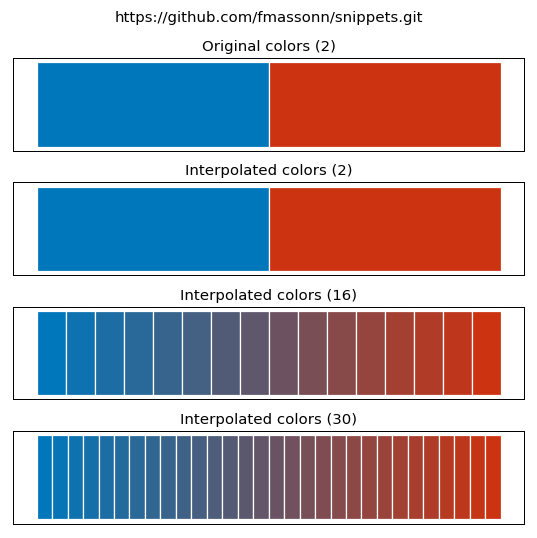

./colInterpolatOr.png printed


In [ ]:
# Color Interpolator
# Given a sequence of N >= 2 colors ("the source"), 
# this script produces a sequence of any M >= 2 colors ("the target")
# with the first and last colors of the target identical to the source,
# and the colors in between equally spaced

# Author - Francois Massonnet (francois.massonnet@uclouvain.be / @FMassonnet)
# Date   - 12 Dec 2022

import matplotlib.pyplot as plt
import numpy as np

def colInterpolatOr(sourceColors, nTarget, colorCode = "RGB"):

  """ - sourceColors is a tuple of colors, by default in RGB format
      - nTarget is the desired number of output colors
      - colorCode : the format, either "RGB" (0-1) or "HEX"
  """

  if colorCode == "HEX":
    # From https://stackoverflow.com/questions/29643352/converting-hex-to-rgb-value-in-python
    sourceColors = [tuple(int(s[i:i + 2], 16) / 255. for i in (1, 3, 5)) for s in sourceColors] 
  elif colorCode != "RGB":
    print("ERROR: color code unknown")
  
  nSource = len(sourceColors)

  # List of output colors
  targetColors = list()


  # Let alpha be a scalar between 0 and 1, where 0 = first source color 
  # and 1 = last source color

  for alpha in np.linspace(0, 1, nTarget):

    # Identify the pair of source colors that will be used 
    # to make the linear interpolation. The variable "iRef" is the 
    # index of the first of these two source colors (iRef is between 0
    # and nSource - 1)

    iRef = int(np.floor(alpha * (nSource - 1)))

    # Reset last index to nSource - 1 since the last color is built 
    # from the last line
    if iRef == nSource - 1:
      iRef -= 1

    # Parameterize the corresponding line and fetch the value at alpha
    # beta is the parameter defining where (0 - 1) we are in between the two
    # source colors involved in the interpolation
    # beta is a simple scaling of alpha for the running interval

    beta = alpha * (nSource - 1) - iRef

    # Build the RGB triplet
    r = sourceColors[iRef][0] + beta * (sourceColors[iRef + 1][0] - sourceColors[iRef][0])
    g = sourceColors[iRef][1] + beta * (sourceColors[iRef + 1][1] - sourceColors[iRef][1])
    b = sourceColors[iRef][2] + beta * (sourceColors[iRef + 1][2] - sourceColors[iRef][2])


    
    if colorCode == "HEX":
      outputColor = '#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255))
    else:   
      outputColor = [r, g, b]

    targetColors.append(outputColor)
  

  return targetColors


# Example


def example():
  # List of colors that we want to pass through
  sourceColors = ["#0077BB", "#CC3311",]
  nSource = len(sourceColors)


  # Number of colors desired
  nTargets = [2, 16, 30]

  fig, ax = plt.subplots(len(nTargets) + 1, 1, figsize = (6, 6))

  for j in np.arange(nSource):
    xStart = j / nSource
    xEnd   = (j + 1) / nSource

    ax[0].fill_between((xStart, xEnd), (1, 1), color = sourceColors[j], edgecolor = "white")
    ax[0].set_title("Original colors (" + str(nSource) + ")")

  for f, n in enumerate(nTargets):
    targetColors = colInterpolatOr(sourceColors, colorCode = "HEX", nTarget = n)
  
    for j in np.arange(n):
      xStart = j / n
      xEnd   = (j + 1) / n

      ax[f + 1].fill_between((xStart, xEnd), (1, 1), color = targetColors[j], edgecolor = "white")
      ax[f + 1].set_title("Interpolated colors (" + str(n) + ")")


  for a in ax.flatten():
    a.set_xticklabels("")
    a.set_yticklabels("")
    a.set_xticks([])
    a.set_yticks([])
  plt.suptitle("https://github.com/fmassonn/snippets.git")
  

  figOut = "./colInterpolatOr.png"
  fig.tight_layout()
  fig.savefig(figOut, dpi = 300)
  print(figOut + " printed")


if __name__ == '__main__':
  example()



## Helping functions

In [ ]:

def k0(T,S) :
     return np.exp(-60.2409+93.4517*(100/T)+23.3585*np.log(T/100)+S*(0.023517-0.023656*(T/100)+0.0047036*(T/100)**2))

def k1(T,S) : 
    mlog10k1 = -62.008+3670.7/T+9.7944*np.log(T)-0.0118*S+0.000116*S**2
    return 10**-mlog10k1
    
def k2(T,S) :
    mlog10k2 = 4.777+1394.7/T-0.0184*S+0.000118*S**2
    return 10**-mlog10k2

def b(M,Q,K1,K2) : 
    return 0.5-Q/(2*M)+(K1*np.sqrt((M-Q)**2-4*K2/K1*Q*(Q-2*M))-4*M*K2)/(2*M*(K1-4*K2))

def h(M,Q,K1,K2) :
    return K1/(2*Q)*(np.sqrt((M-Q)**2-4*K2/K1*Q*(Q-2*M))+M-Q)

def CO32U(M,Q,K1,K2) :
    B = b(M,Q,K1,K2)
    return (Q + M*(B-1))/(WU*carbon_molar_mass)*10**18

def CO32D(M,Q,K1,K2) :
    B = b(M,Q,K1,K2)
    return (Q + M*(B-1))/(WD*carbon_molar_mass)*10**18

def species(sol,T,S,**kwargs):
    
    W =np.array([WU,WI,WD])
    
    if kwargs['ktemp'] == True : 
        ktemp = 1
    else: ktemp = 0
            
    if kwargs['level'] == 'U' :
        i = 0
    elif kwargs['level'] == 'I' : 
        i = 1
    else: i = 2
    
    temp = T + ktemp*sol.y[9+i]
    
    K0 = k0(temp,S)
    K1 = k1(temp,S)
    K2 = k2(temp,S)

    B = b(sol.y[2+i],sol.y[5+i],K1,K2)
    H = h(sol.y[2+i],sol.y[5+i],K1,K2)

    CO3 = (sol.y[5+i] + sol.y[2+i]*(B-1))/(W[i]*carbon_molar_mass)*10**18
    HCO3 = H*CO3/K2
    H2CO3 = H*HCO3/K1
    
    return H,H2CO3,HCO3,CO3


def species_o(sol,T_U,S_U,T_D,S_D):
    
    tempU = T_U 
    
    K0U = k0(tempU,S_U)
    K1U = k1(tempU,S_U)
    K2U = k2(tempU,S_U)
    
    BU = b(sol.y[1],sol.y[4],K1U,K2U)
    HU = h(sol.y[1],sol.y[4],K1U,K2U)
    
    CO3U = (sol.y[4] + sol.y[1]*(BU-1))/(WU*carbon_molar_mass)*10**18
    HCO3U = HU*CO3U/K2U
    H2CO3U = HU*HCO3U/K1U
    
    tempD = T_D + sol.y[8]
    
    K0D = k0(tempD,S_D)
    K1D = k1(tempD,S_D)
    K2D = k2(tempD,S_D)
    
    BD = b(sol.y[2],sol.y[5],K1D,K2D)
    HD = h(sol.y[2],sol.y[5],K1D,K2D)
    
    CO3D = (sol.y[5] + sol.y[2]*(BD-1))/(WD*carbon_molar_mass)*10**18
    HCO3D = HD*CO3D/K2D
    H2CO3D = HD*HCO3D/K1D
    
    return HU,H2CO3U,HCO3U,CO3U,HD,H2CO3D,HCO3D,CO3D

def init_DICU(T_U,S_U,alk_U,pCO2_A):
    
    K0U = k0(T_U,S_U)
    K1U = k1(T_U,S_U)
    K2U = k2(T_U,S_U)
    H2CO3U = K0U*pCO2_A + K0U/(mA*carbon_molar_mass*10**-18*K_AU)*((1-X)*(F_CaCO3_pi+F_CaSiO3_pi)+F_LR)
    HU = (K1U + np.sqrt(K1U**2+8*alk_U*K1U*K2U/H2CO3U))/(2*alk_U/H2CO3U)
    HCO3U = K1U*H2CO3U/HU
    CO3U = K2U*HCO3U/HU
    DIC_U = H2CO3U+HCO3U+CO3U
    
    return DIC_U 

def init_DICD(T_D,S_D,alk_D,CO32_D) : 
    
    K0D = k0(T_D,S_D)
    K1D = k1(T_D,S_D)
    K2D = k2(T_D,S_D)
    HCO3D = alk_D-2*CO32_D
    HD = K2D*HCO3D/CO32_D
    H2CO3D = HD*HCO3D/K1D
    DIC_D = H2CO3D+HCO3D+CO32_D
    
    return DIC_D 

alpha_U = 2.3*10**-4
alpha_I = 1.3*10**-4
alpha_D = 1.3*10**-4

def SLR(sol) :
    S_th = alpha_U*hu*sol.y[9] + alpha_I*hi*sol.y[10] + alpha_D*hd*sol.y[11]
    S_gl = sol.y[14]
    S_GRIS = Spot_GRIS*(1-sol.y[15])
    S_WAIS = Spot_WAIS*(1-sol.y[16])
    S_EASB = Spot_EASB*(1-sol.y[17])
    S_EAIS = Spot_EAIS*(1-sol.y[18])
    return S_th + S_gl + S_GRIS + S_WAIS + S_EASB + S_EAIS


## SURFER parameters for this whole notebook

In [ ]:
hu=150
hi=500
hd=2500

WU=mO*water_molar_mass*hu/(hu+hi+hd)
WI=mO*water_molar_mass*hi/(hu+hi+hd)
WD=mO*water_molar_mass*hd/(hu+hi+hd)

V = 0.065
F_CaCO3_pi = 0.065
F_CaSiO3_pi = 0.065
X = 1
F_LR = 0

K_AL = 0.025
beta_L=1.7
K_AU = 0.25
K_UI = 0.023*5
K_ID = 0.023*0.35
K_alk_UI = 0.021*5
K_alk_ID = 0.021*0.35

T_U = 273.15 + 17.4
S_U = 34.6
alk_U = 2215
pCO2_A = 280
DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A)

T_D = 273.15 + 1.73
S_D = 34.73
alk_D = 2336
CO32_D = 87
DIC_D = init_DICD(T_D,S_D,alk_D,CO32_D)

T_I = (T_U + T_D)/2
S_I = (S_U + S_D)/2 # not sure if this is valid
alk_I = (alk_U+alk_D)/2 # not sure if this is valid
DIC_I = (DIC_U + DIC_D)/2

MA_pi = 580.3
ML_pi = 2200
MU_pi = DIC_U*WU*carbon_molar_mass*10**-18
MI_pi = DIC_I*WI*carbon_molar_mass*10**-18
MD_pi = DIC_D*WD*carbon_molar_mass*10**-18
QU_pi = alk_U*WU*carbon_molar_mass*10**-18
QI_pi = alk_I*WI*carbon_molar_mass*10**-18
QD_pi = alk_D*WD*carbon_molar_mass*10**-18

ch4_pi = 720
Mch4_pi = ch4_pi*mA*carbon_molar_mass*10**-21

## Tipping points

In [ ]:
def xm_today(op,om,xp) :
    G = (op+om+2*(op*om)**0.5)/(op-om)
    return (-2+xp*(1+G**(1/3)+G**(-1/3)))/(-1+G**(1/3)+G**(-1/3))

def a2(op,om,xp,xm):
    return 3/2*(xp+xm)

def a1(op,om,xp,xm):
    return -3*xp*xm

def c1(op,om,xp,xm):
    return -(xp-xm)**3/(2*(op-om))

def c0(op,om,xp,xm):
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))

def params(op,om,xp) : 
    xm = xm_today(op,om,xp)
    a_2 = a2(op,om,xp,xm)
    a_1 = a1(op,om,xp,xm)
    c_1 = c1(op,om,xp,xm)
    c_0 = c0(op,om,xp,xm)
    return a_2,a_1,c_1,c_0


<IPython.core.display.Javascript object>


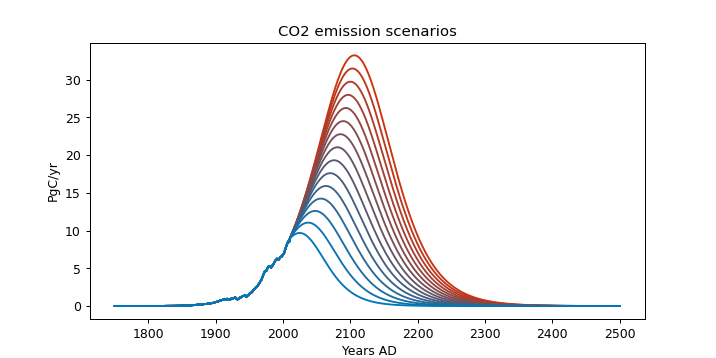

Text(0.5, 1.0, 'CO2 emission scenarios')

In [ ]:
Nexp = 15
sourceColors = ["#0077BB", "#CC3311",]
targetColors = colInterpolatOr(sourceColors, colorCode = "HEX", nTarget = Nexp)

fig,ax1 = plt.subplots(1,1,figsize=(8,4),sharex= True)

time = np.linspace(0,750,1000)
aa = np.linspace(1000,5000,Nexp)

for i in range(0,Nexp) : 
    
    co2_fossil = forcingCO2(2010,aa[i],mode='total',landuse= False, origin=1750) 
    ax1.plot(time+1750,co2_fossil(time),c=targetColors[i],zorder = Nexp-i)

ax1.set_ylabel('PgC/yr')
ax1.set_xlabel(' Years AD')
ax1.set_title('CO2 emission scenarios')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/scenarios.pdf")

In [ ]:
# Couplings between tipping points

S_moy = np.zeros((8,8))

S_moy[0,1] = 1.5 # WAIS -> GRIS
S_moy[0,2] = 1.5 # EASB -> GRIS
S_moy[0,5] = -11/2 # AMOC -> GRIS

S_moy[1,0] = 11/2 # GRIS -> WAIS
S_moy[1,5] = 1.25 # AMOC -> WAIS

S_moy[2,0] = 11/2 # GRIS -> EASB
S_moy[2,5] = 1.25 # AMOC -> EASB

S_moy[4,5] = -1.5 # AMOC -> AWSI
# S_moy[4,5] = 0 # AMOC -> AWSI

S_moy[5,4] = 1.5 # AWSI -> AMOC
# S_moy[5,4] = 0 # AWSI -> AMOC

S_moy[6,5] = 0.5 # AMOC -> AMAZ

S_moy = S_moy/5

c_50 = (11/2)/5*2900 # dGRIS -> AMOC
c_51 = 0 # dWAIS -> AMOC
c_52 = 0 # dEASB -> AMOC

# Feedback on radiative forcing

fmod_GRIS = 0.43
fmod_WAIS = 0.18
fmod_EASB = 0.18
fmod_EAIS = 0.60
fmod_AWSI = 0.60
fmod_AMOC = 0.00
fmod_AMAZ = 0.00
fmod_PERM = 0.00

# Feedback on emmissions

cpot_GRIS = 0
cpot_WAIS = 0
cpot_EASB = 0
cpot_EAIS = 0
cpot_AWSI = 0
cpot_AMOC = 0
cpot_AMAZ = 75
cpot_PERM = 500 *0.8

ch4pot_GRIS = 0
ch4pot_WAIS = 0
ch4pot_EASB = 0
ch4pot_EAIS = 0
ch4pot_AWSI = 0
ch4pot_AMOC = 0
ch4pot_AMAZ = 75
ch4pot_PERM = 500 *0.2

## Tipping points - normal case

In [ ]:
# 0 - GRIS

Tp_GRIS = 1.52
Tm_GRIS = 0.3
Vp_GRIS = 0.77
taup_GRIS = 2000
taum_GRIS = 2000
a2_GRIS,a1_GRIS,c1_GRIS,c0_GRIS = params(Tp_GRIS,Tm_GRIS,Vp_GRIS)

# 1 - WAIS

Tp_WAIS = 1.5
Tm_WAIS = 0.3
Vp_WAIS = 0.75
taup_WAIS = 2000
taum_WAIS = 2000
a2_WAIS,a1_WAIS,c1_WAIS,c0_WAIS = params(Tp_WAIS,Tm_WAIS,Vp_WAIS)

# 2 - EASB

Tp_EASB = 3
Tm_EASB = 0.3
Vp_EASB = 0.75
taup_EASB = 2000
taum_EASB = 2000
a2_EASB,a1_EASB,c1_EASB,c0_EASB = params(Tp_EASB,Tm_EASB,Vp_EASB)

# 3 - EAIS

Tp_EAIS = 7.5
Tm_EAIS = 4.0
Vp_EAIS = 0.44
taup_EAIS = 10000
taum_EAIS = 10000
a2_EAIS,a1_EAIS,c1_EAIS,c0_EAIS = params(Tp_EAIS,Tm_EAIS,Vp_EAIS)

# 4 - AWSI

Tp_AWSI = 6.3
Tm_AWSI = 2.5
Vp_AWSI = 0.7
taup_AWSI = 20
taum_AWSI = 20
a2_AWSI,a1_AWSI,c1_AWSI,c0_AWSI = params(Tp_AWSI,Tm_AWSI,Vp_AWSI)

# 5 - AMOC

Tp_AMOC = 4
Tm_AMOC = 0
Vp_AMOC = 0.77
taup_AMOC = 50
taum_AMOC = 50
a2_AMOC,a1_AMOC,c1_AMOC,c0_AMOC = params(Tp_AMOC,Tm_AMOC,Vp_AMOC)

# 6 - AMAZ

Tp_AMAZ = 3.5
Tm_AMAZ = 0
Vp_AMAZ = 0.77
taup_AMAZ = 100
taum_AMAZ = 100
a2_AMAZ,a1_AMAZ,c1_AMAZ,c0_AMAZ = params(Tp_AMAZ,Tm_AMAZ,Vp_AMAZ)

# 7 - PERM

Tp_PERM = 4
Tm_PERM = 0
Vp_PERM = 0.75
taup_PERM = 50
taum_PERM = 50
a2_PERM,a1_PERM,c1_PERM,c0_PERM = params(Tp_PERM,Tm_PERM,Vp_PERM)

### SLR ###

Spot_GRIS = 7
Spot_WAIS = 5
Spot_EASB = 9
Spot_EAIS = 45

<IPython.core.display.Javascript object>


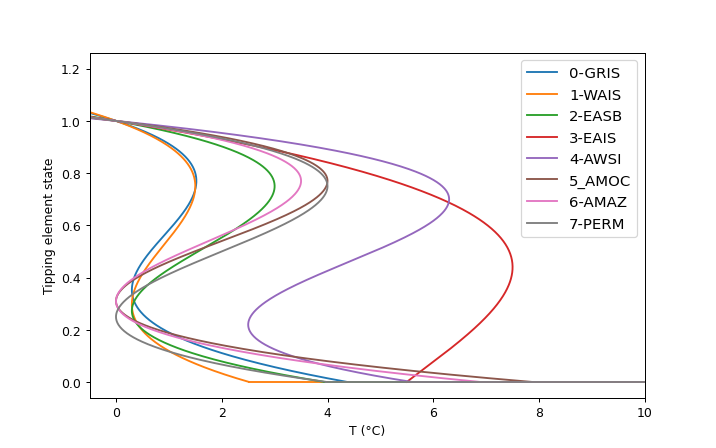

Text(0, 0.5, 'Tipping element state')

In [ ]:
A2 = np.array([a2_GRIS,a2_WAIS,a2_EASB,a2_EAIS,a2_AWSI,a2_AMOC,a2_AMAZ,a2_PERM])
A1 = np.array([a1_GRIS,a1_WAIS,a1_EASB,a1_EAIS,a1_AWSI,a1_AMOC,a1_AMAZ,a1_PERM])
C1 = np.array([c1_GRIS,c1_WAIS,c1_EASB,c1_EAIS,c1_AWSI,c1_AMOC,c1_AMAZ,c1_PERM])
C0 = np.array([c0_GRIS,c0_WAIS,c0_EASB,c0_EAIS,c0_AWSI,c0_AMOC,c0_AMAZ,c0_PERM])

labels = ['0-GRIS','1-WAIS','2-EASB','3-EAIS','4-AWSI','5_AMOC','6-AMAZ','7-PERM']
colors = ['C0','C1','C2','C3','C4','C5','C6','C7']

fig, ax = plt.subplots(1,1,figsize=(8,5))
    
for i in range(0,8):
    
    x = np.linspace(-0.8,1.2,1000)
    y = -1*(-x**3+A2[i]*x**2+A1[i]*x+C0[i])/C1[i]

    ax.plot(y[x>0],x[x>0],c=colors[i],label = labels[i])
    ax.plot([y[x>0][0],17],[0,0],c=colors[i])
    
ax.set_xlim((-0.5,10))
ax.legend(fontsize=12)

ax.set_xlabel('T (°C)')
ax.set_ylabel('Tipping element state')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/bifurcationdiags_normalcase.pdf")

In [ ]:
A2 = np.array([a2_GRIS,a2_WAIS,a2_EASB,a2_EAIS,a2_AWSI,a2_AMOC,a2_AMAZ,a2_PERM])
A1 = np.array([a1_GRIS,a1_WAIS,a1_EASB,a1_EAIS,a1_AWSI,a1_AMOC,a1_AMAZ,a1_PERM])
C1 = np.array([c1_GRIS,c1_WAIS,c1_EASB,c1_EAIS,c1_AWSI,c1_AMOC,c1_AMAZ,c1_PERM])
C0 = np.array([c0_GRIS,c0_WAIS,c0_EASB,c0_EAIS,c0_AWSI,c0_AMOC,c0_AMAZ,c0_PERM])
TAUP = np.array([taup_GRIS,taup_WAIS,taup_EASB,taup_EAIS,taup_AWSI,taup_AMOC,taup_AMAZ,taup_PERM])
TAUM = np.array([taum_GRIS,taum_WAIS,taum_EASB,taum_EAIS,taum_AWSI,taum_AMOC,taum_AMAZ,taum_PERM])

FMOD = np.array([fmod_GRIS,fmod_WAIS,fmod_EASB,fmod_EAIS,fmod_AWSI,fmod_AMOC,fmod_AMAZ,fmod_PERM])
CPOT = np.array([cpot_GRIS,cpot_WAIS,cpot_EASB,cpot_EAIS,cpot_AWSI,cpot_AMOC,cpot_AMAZ,cpot_PERM])
CH4POT = np.array([ch4pot_GRIS,ch4pot_WAIS,ch4pot_EASB,ch4pot_EAIS,ch4pot_AWSI,ch4pot_AMOC,ch4pot_AMAZ,ch4pot_PERM])


### Baseline

In [ ]:
Nexp = 15

sourceColors = ["#0077BB", "#CC3311",]
targetColors = colInterpolatOr(sourceColors, colorCode = "HEX", nTarget = Nexp)


t0=0 ; tend=500000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]

co2_landuse = zero_forcing(teval)
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

cfeedback = 0
d= 0.0
epsi = 0

solutions_0 = []
    
for i in range(0,Nexp) : 
    
    co2_fossil = forcingCO2(2010,aa[i],mode='total',landuse= False, origin=1750) 
    sol = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')
    solutions_0.append(sol)
    print(aa[i], 'done')
    

1000.0 done
1285.7142857142858 done
1571.4285714285716 done
1857.142857142857 done
2142.857142857143 done
2428.5714285714284 done
2714.285714285714 done
3000.0 done
3285.714285714286 done
3571.4285714285716 done
3857.1428571428573 done
4142.857142857143 done
4428.571428571428 done
4714.285714285714 done
5000.0 done


<IPython.core.display.Javascript object>


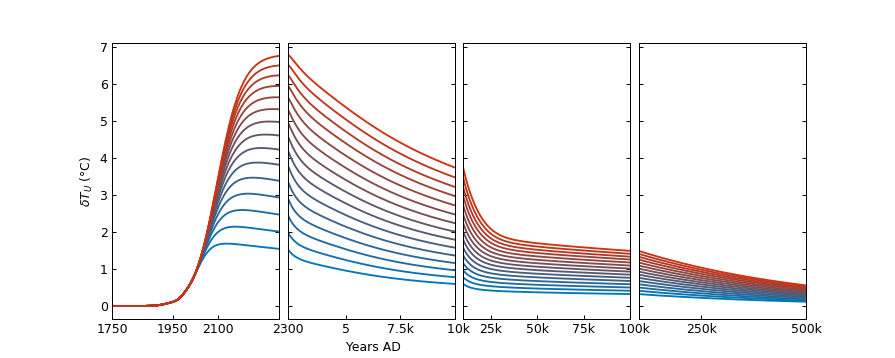

Text(0.5, 0, ' Years AD')

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1])
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(10,4),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol0 = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol0.t[time]+1750,sol0.y[9][time],c=targetColors[i],ls='-')
        
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))



ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top


#for axes in [ax1,ax2,ax3,ax4] : 
#    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
      
ax1.set_xticks([1750,1950,2100])
ax1.set_xticklabels(['1750','1950','2100'])
ax2.set_xticks([2300,5000,7500,10000])
ax2.set_xticklabels(['2300','5','7.5k','  10k'])
ax3.set_xticks([25000,50000,75000,100000])
ax3.set_xticklabels(['25k','50k','75k','  100k'])
ax4.set_xticks([250000,500000])
ax4.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'$\delta T_U$ (°C)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

ax2.set_xlabel(' Years AD')


In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/baseline_temp.pdf")

<IPython.core.display.Javascript object>


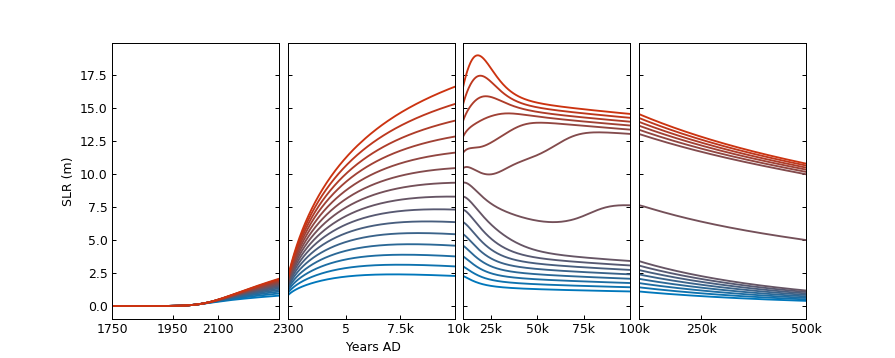

Text(0.5, 0, ' Years AD')

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1])
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(10,4),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,SLR(sol)[time],c=targetColors[i],ls='-')
        
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))



ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top


#for axes in [ax1,ax2,ax3,ax4] : 
#    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
      
ax1.set_xticks([1750,1950,2100])
ax1.set_xticklabels(['1750','1950','2100'])
ax2.set_xticks([2300,5000,7500,10000])
ax2.set_xticklabels(['2300','5','7.5k','  10k'])
ax3.set_xticks([25000,50000,75000,100000])
ax3.set_xticklabels(['25k','50k','75k','  100k'])
ax4.set_xticks([250000,500000])
ax4.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'SLR (m)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

ax2.set_xlabel(' Years AD')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/baseline_slr.pdf")

<IPython.core.display.Javascript object>


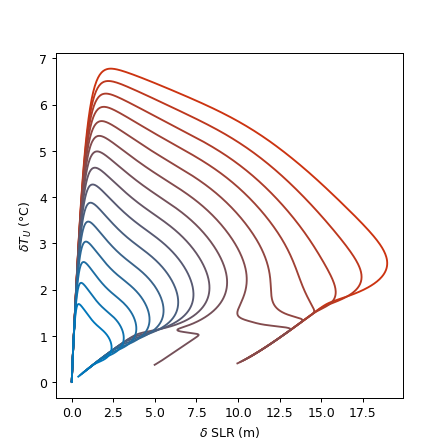

Text(0, 0.5, '$\\delta T_U$ (°C)')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

for i in range(0,Nexp) :
    sol = solutions_0[i]
    ax.plot(SLR(sol)[time],sol.y[9][time],c=targetColors[i],zorder = Nexp-i)

    
ax.set_xlabel(r'$\delta$ SLR (m)')
ax.set_ylabel(r'$\delta T_U$ (°C)')

<IPython.core.display.Javascript object>


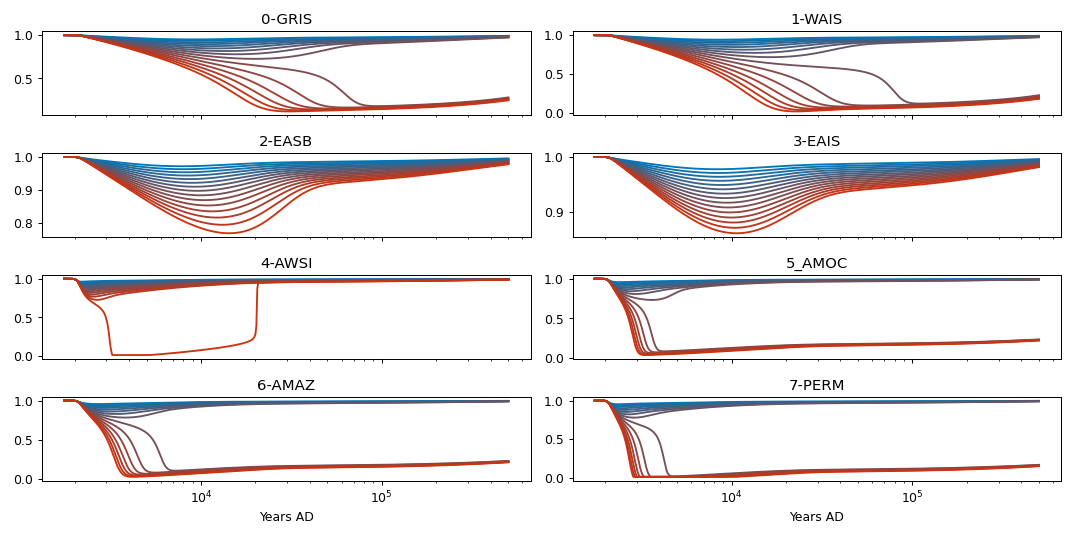

In [ ]:

fig,[[ax0,ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(12,6),sharex= True)

for i in range(0,Nexp) :
    
    sol = solutions_0[i]
    
#    ax0.plot(sol.t[time]+1750, slr[time],c=targetColors[i])
#    ax0.plot(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
#    ax1.plot(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
#    ax2.plot(sol.t[time]+1750, sol.y[17][time],c=targetColors[i])
#    ax3.plot(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
#    ax4.plot(sol.t[time]+1750, sol.y[19][time],c=targetColors[i])
#    ax5.plot(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
#    ax6.plot(sol.t[time]+1750, sol.y[21][time],c=targetColors[i])
#    ax7.plot(sol.t[time]+1750, sol.y[22][time],c=targetColors[i])
    

    
    ax0.semilogx(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
    ax1.semilogx(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
    ax2.semilogx(sol.t[time]+1750, sol.y[17][time],c=targetColors[i])
    ax3.semilogx(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
    ax4.semilogx(sol.t[time]+1750, sol.y[19][time],c=targetColors[i])
    ax5.semilogx(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    ax6.semilogx(sol.t[time]+1750, sol.y[21][time],c=targetColors[i])
    ax7.semilogx(sol.t[time]+1750, sol.y[22][time],c=targetColors[i])

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]    

for i in range(0,8):
    axes[i].set_title(labels[i])
    
ax6.set_xlabel('Years AD')
ax7.set_xlabel('Years AD')
    
#ax0.set_xlim((10000,100000))
    
plt.tight_layout()

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/baseline_tps.pdf")

### Without interactions

In [ ]:
Nexp = 15

sourceColors = ["#0077BB", "#CC3311",]
targetColors = colInterpolatOr(sourceColors, colorCode = "HEX", nTarget = Nexp)


t0=0 ; tend=500000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]

co2_landuse = zero_forcing(teval)
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

cfeedback = 1
d= 0
epsi = 1

aa = np.linspace(1000,5000,Nexp)
print(aa)

solutions = []

time = (np.rint(np.logspace(0,7,1000))).astype(int)-1

for i in range(0,Nexp) : 
    
    co2_fossil = forcingCO2(2010,aa[i],mode='total',landuse= False, origin=1750) 
    sol = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')
    solutions.append(sol)
    print(aa[i], 'done') 

[1000.         1285.71428571 1571.42857143 1857.14285714 2142.85714286
 2428.57142857 2714.28571429 3000.         3285.71428571 3571.42857143
 3857.14285714 4142.85714286 4428.57142857 4714.28571429 5000.        ]
1000.0 done
1285.7142857142858 done
1571.4285714285716 done
1857.142857142857 done
2142.857142857143 done
2428.5714285714284 done
2714.285714285714 done
3000.0 done
3285.714285714286 done
3571.4285714285716 done
3857.1428571428573 done
4142.857142857143 done
4428.571428571428 done
4714.285714285714 done
5000.0 done


<IPython.core.display.Javascript object>


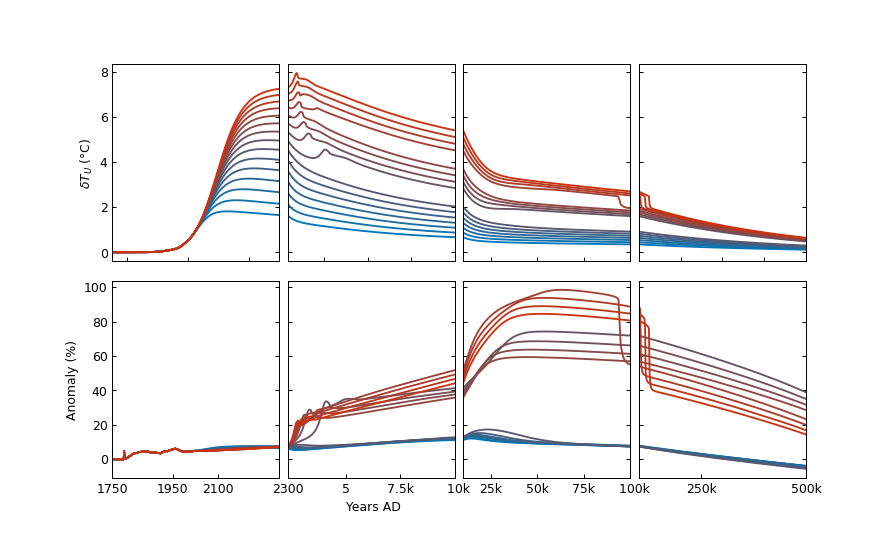

/tmp/ipykernel_111039/4190850244.py:18: RuntimeWarning: invalid value encountered in divide
  axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time])/sol0.y[9][time]*100,c=targetColors[i])


Text(0.5, 0, ' Years AD')

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4, figsize=(10,6),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions[i]
    sol0 = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,sol.y[9][time],c=targetColors[i])
             #axes.plot(sol0.t[time]+1750,sol0.y[9][time],c=targetColors[i],ls='--')
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
            axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time])/sol0.y[9][time]*100,c=targetColors[i])
         #   axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time]),c=targetColors[i])
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
      
ax5.set_xticks([1750,1950,2100])
ax5.set_xticklabels(['1750','1950','2100'])
ax6.set_xticks([2300,5000,7500,10000])
ax6.set_xticklabels(['2300','5','7.5k','  10k'])
ax7.set_xticks([25000,50000,75000,100000])
ax7.set_xticklabels(['25k','50k','75k','  100k'])
ax8.set_xticks([250000,500000])
ax8.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'$\delta T_U$ (°C)')
ax5.set_ylabel(r'Anomaly (%)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

ax6.set_xlabel(' Years AD')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/noint_temp.pdf")

<IPython.core.display.Javascript object>


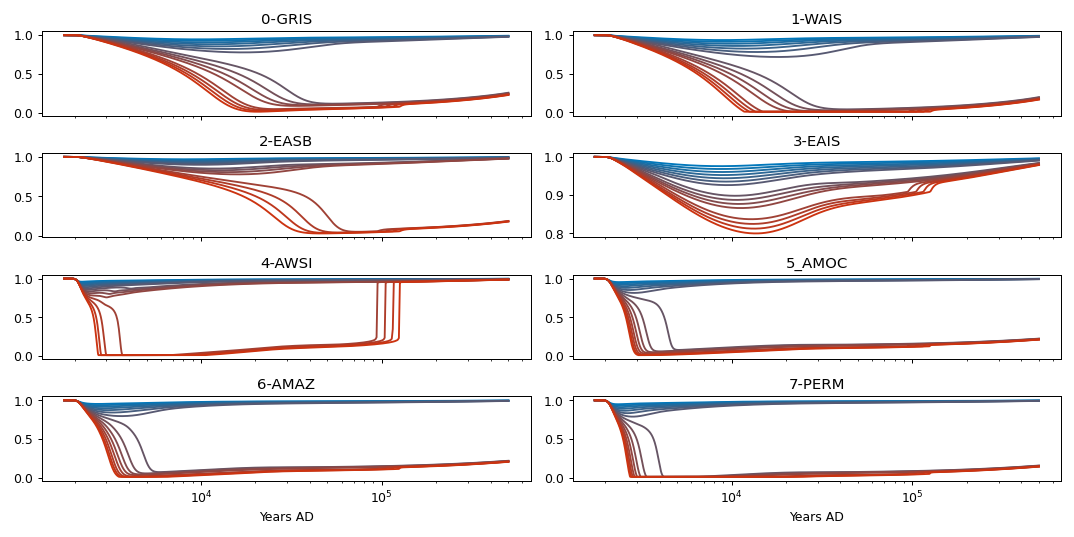

In [ ]:

fig,[[ax0,ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(12,6),sharex= True)

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
#     ax1.plot(sol.t[time]+1750,sol.y[0][time]/2.0724,c=targetColors[i])
#     ax2.plot(sol.t[time]+1750, sol.y[9][time],c=targetColors[i])
# #     ax3.plot(sol.t[time]+1750,SLR(sol),c=targetColors[i])
#     ax4.plot(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
#     ax5.plot(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
#     ax6.plot(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
#     ax7.plot(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    
    ax0.semilogx(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
    ax1.semilogx(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
    ax2.semilogx(sol.t[time]+1750, sol.y[17][time],c=targetColors[i])
    ax3.semilogx(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
    ax4.semilogx(sol.t[time]+1750, sol.y[19][time],c=targetColors[i])
    ax5.semilogx(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    ax6.semilogx(sol.t[time]+1750, sol.y[21][time],c=targetColors[i])
    ax7.semilogx(sol.t[time]+1750, sol.y[22][time],c=targetColors[i])

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]    

for i in range(0,8):
    axes[i].set_title(labels[i])
    
ax6.set_xlabel('Years AD')
ax7.set_xlabel('Years AD')
    
plt.tight_layout()

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/noint_TPs.pdf")

<IPython.core.display.Javascript object>


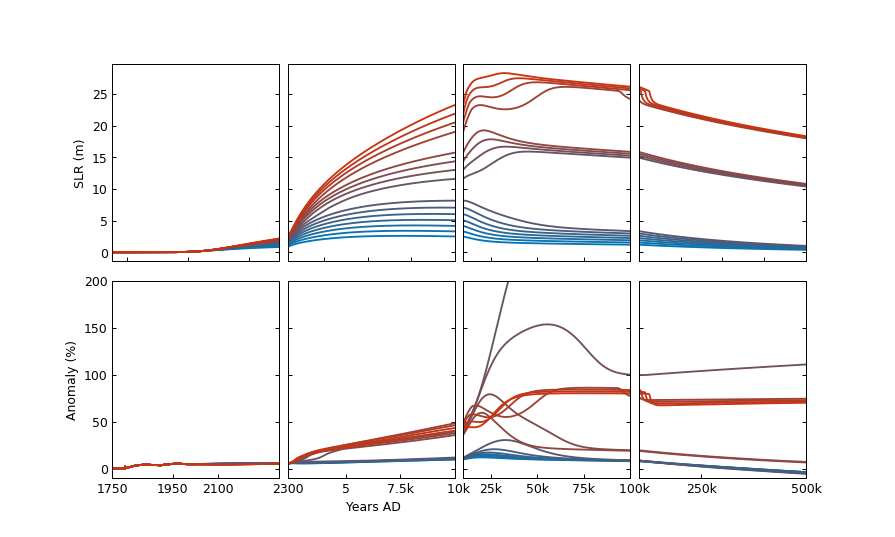

/tmp/ipykernel_111039/2212400085.py:18: RuntimeWarning: invalid value encountered in divide
  axes.plot(sol.t[time]+1750,(SLR(sol)[time]-SLR(sol0)[time])/SLR(sol0)[time]*100,c=targetColors[i])


Text(0.5, 0, ' Years AD')

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4, figsize=(10,6),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions[i]
    sol0 = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,SLR(sol)[time],c=targetColors[i])
             #axes.plot(sol0.t[time]+1750,sol0.y[9][time],c=targetColors[i],ls='--')
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
        axes.plot(sol.t[time]+1750,(SLR(sol)[time]-SLR(sol0)[time])/SLR(sol0)[time]*100,c=targetColors[i])
        #axes.plot(sol.t[time]+1750,(SLR(sol)[time]-SLR(sol0)[time]),c=targetColors[i])
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
    
for axes in [ax5,ax6,ax7,ax8] : 
    axes.set_ylim((-10,200))
      
ax5.set_xticks([1750,1950,2100])
ax5.set_xticklabels(['1750','1950','2100'])
ax6.set_xticks([2300,5000,7500,10000])
ax6.set_xticklabels(['2300','5','7.5k','  10k'])
ax7.set_xticks([25000,50000,75000,100000])
ax7.set_xticklabels(['25k','50k','75k','  100k'])
ax8.set_xticks([250000,500000])
ax8.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'SLR (m)')
ax5.set_ylabel(r'Anomaly (%)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

ax6.set_xlabel(' Years AD')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/noint_slr.pdf")

<IPython.core.display.Javascript object>


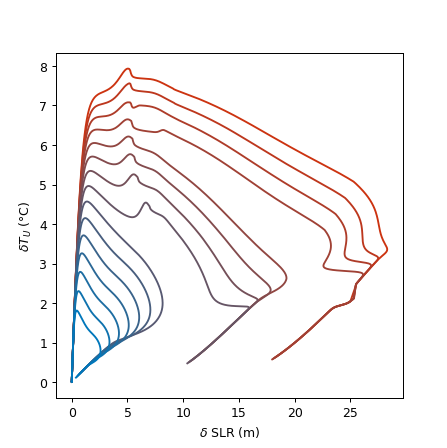

Text(0, 0.5, '$\\delta T_U$ (°C)')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

for i in range(0,Nexp) :
    sol = solutions[i]
    ax.plot(SLR(sol)[time],sol.y[9][time],c=targetColors[i],zorder = Nexp-i)

    
ax.set_xlabel(r'$\delta$ SLR (m)')
ax.set_ylabel(r'$\delta T_U$ (°C)')



In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/noint_tempslr.pdf")

### With interactions

In [ ]:
Nexp = 15

sourceColors = ["#0077BB", "#CC3311",]
targetColors = colInterpolatOr(sourceColors, colorCode = "HEX", nTarget = Nexp)


t0=0 ; tend=500000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]

co2_landuse = zero_forcing(teval)
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

cfeedback = 1
d= 0.5
epsi = 1

aa = np.linspace(1000,5000,Nexp)
print(aa)

solutions = []

time = (np.rint(np.logspace(0,7,1000))).astype(int)-1

for i in range(0,Nexp) : 
    
    co2_fossil = forcingCO2(2010,aa[i],mode='total',landuse= False, origin=1750) 
    sol = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')
    solutions.append(sol)
    print(aa[i], 'done') 

[1000.         1285.71428571 1571.42857143 1857.14285714 2142.85714286
 2428.57142857 2714.28571429 3000.         3285.71428571 3571.42857143
 3857.14285714 4142.85714286 4428.57142857 4714.28571429 5000.        ]
1000.0 done
1285.7142857142858 done
1571.4285714285716 done
1857.142857142857 done
2142.857142857143 done
2428.5714285714284 done
2714.285714285714 done
3000.0 done
3285.714285714286 done
3571.4285714285716 done
3857.1428571428573 done
4142.857142857143 done
4428.571428571428 done
4714.285714285714 done
5000.0 done


<IPython.core.display.Javascript object>


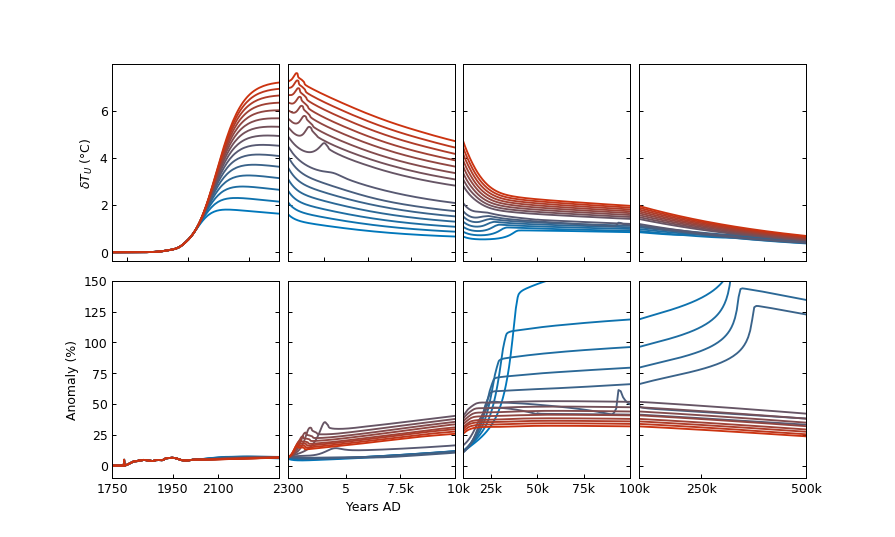

/tmp/ipykernel_111039/3363422147.py:18: RuntimeWarning: invalid value encountered in divide
  axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time])/sol0.y[9][time]*100,c=targetColors[i])


Text(0.5, 0, ' Years AD')

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4, figsize=(10,6),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions[i]
    sol0 = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,sol.y[9][time],c=targetColors[i])
             #axes.plot(sol0.t[time]+1750,sol0.y[9][time],c=targetColors[i],ls='--')
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
            axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time])/sol0.y[9][time]*100,c=targetColors[i])
            #axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time]),c=targetColors[i])
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)


for axes in [ax5,ax6,ax7,ax8] : 
    axes.set_ylim((-10,150))
    
ax5.set_xticks([1750,1950,2100])
ax5.set_xticklabels(['1750','1950','2100'])
ax6.set_xticks([2300,5000,7500,10000])
ax6.set_xticklabels(['2300','5','7.5k','  10k'])
ax7.set_xticks([25000,50000,75000,100000])
ax7.set_xticklabels(['25k','50k','75k','  100k'])
ax8.set_xticks([250000,500000])
ax8.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'$\delta T_U$ (°C)')
ax5.set_ylabel(r'Anomaly (%)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

ax6.set_xlabel(' Years AD')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/int_temp.pdf")

<IPython.core.display.Javascript object>


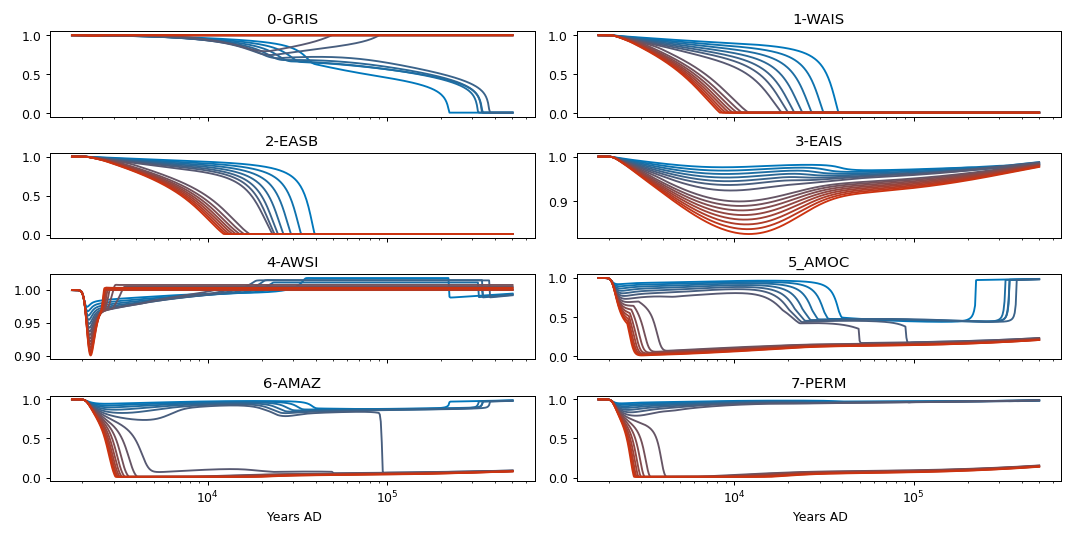

In [ ]:
fig,[[ax0,ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(12,6),sharex= True)

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
#     ax1.plot(sol.t[time]+1750,sol.y[0][time]/2.0724,c=targetColors[i])
#     ax2.plot(sol.t[time]+1750, sol.y[9][time],c=targetColors[i])
# #     ax3.plot(sol.t[time]+1750,SLR(sol),c=targetColors[i])
#     ax4.plot(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
#     ax5.plot(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
#     ax6.plot(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
#     ax7.plot(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    
    ax0.semilogx(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
    ax1.semilogx(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
    ax2.semilogx(sol.t[time]+1750, sol.y[17][time],c=targetColors[i])
    ax3.semilogx(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
    ax4.semilogx(sol.t[time]+1750, sol.y[19][time],c=targetColors[i])
    ax5.semilogx(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    ax6.semilogx(sol.t[time]+1750, sol.y[21][time],c=targetColors[i])
    ax7.semilogx(sol.t[time]+1750, sol.y[22][time],c=targetColors[i])

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]    

for i in range(0,8):
    axes[i].set_title(labels[i])
    
ax6.set_xlabel(' Years AD')
ax7.set_xlabel(' Years AD')
    
plt.tight_layout()

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/int_TPs.pdf")

<IPython.core.display.Javascript object>


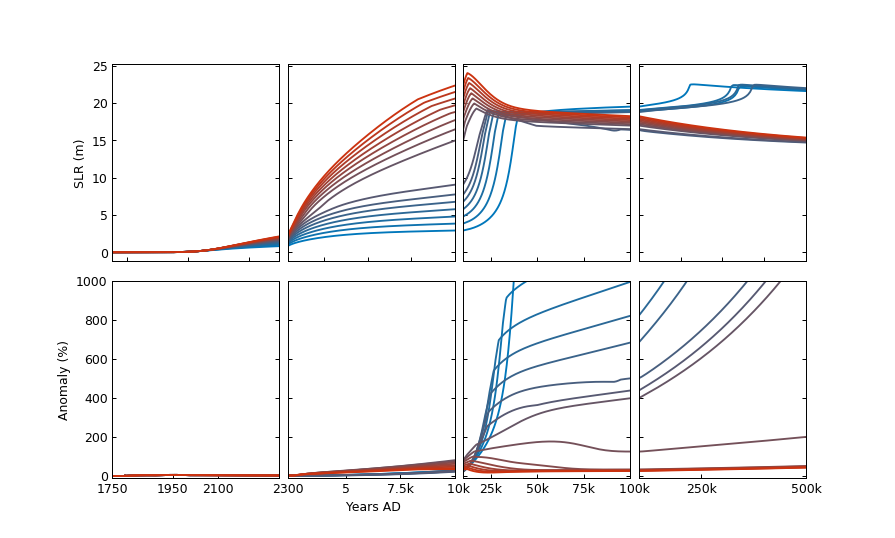

/tmp/ipykernel_111039/2431765149.py:18: RuntimeWarning: invalid value encountered in divide
  axes.plot(sol.t[time]+1750,(SLR(sol)[time]-SLR(sol0)[time])/SLR(sol0)[time]*100,c=targetColors[i])


In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4, figsize=(10,6),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions[i]
    sol0 = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,SLR(sol)[time],c=targetColors[i])
             #axes.plot(sol0.t[time]+1750,sol0.y[9][time],c=targetColors[i],ls='--')
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
        axes.plot(sol.t[time]+1750,(SLR(sol)[time]-SLR(sol0)[time])/SLR(sol0)[time]*100,c=targetColors[i])
        #axes.plot(sol.t[time]+1750,(SLR(sol)[time]-SLR(sol0)[time]),c=targetColors[i])
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
    
for axes in [ax5,ax6,ax7,ax8] : 
    axes.set_ylim((-10,1000))
      
ax5.set_xticks([1750,1950,2100])
ax5.set_xticklabels(['1750','1950','2100'])
ax6.set_xticks([2300,5000,7500,10000])
ax6.set_xticklabels(['2300','5','7.5k','  10k'])
ax7.set_xticks([25000,50000,75000,100000])
ax7.set_xticklabels(['25k','50k','75k','  100k'])
ax8.set_xticks([250000,500000])
ax8.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'SLR (m)')
ax5.set_ylabel(r'Anomaly (%)')

ax6.set_xlabel(' Years AD')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 


In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/int_slr.pdf")

<IPython.core.display.Javascript object>


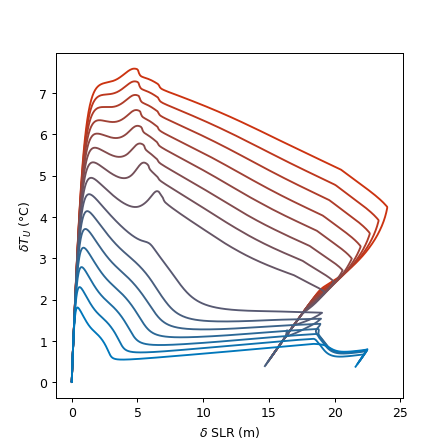

Text(0, 0.5, '$\\delta T_U$ (°C)')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

for i in range(0,Nexp) :
    sol = solutions[i]
    ax.plot(SLR(sol)[time],sol.y[9][time],c=targetColors[i],zorder = Nexp-i)

    
ax.set_xlabel(r'$\delta$ SLR (m)')
ax.set_ylabel(r'$\delta T_U$ (°C)')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/int_tempslr.pdf")

## Tipping points - Worst case scenario


In [ ]:
# 0 - GRIS

Tp_GRIS = 0.8
Tm_GRIS = 0.3
Vp_GRIS = 0.77
taup_GRIS = 1000
taum_GRIS = 1000
a2_GRIS,a1_GRIS,c1_GRIS,c0_GRIS = params(Tp_GRIS,Tm_GRIS,Vp_GRIS)

# 1 - WAIS

Tp_WAIS = 1
Tm_WAIS = 0.3
Vp_WAIS = 0.75
taup_WAIS = 500
taum_WAIS = 500
a2_WAIS,a1_WAIS,c1_WAIS,c0_WAIS = params(Tp_WAIS,Tm_WAIS,Vp_WAIS)

# 2 - EASB

Tp_EASB = 2
Tm_EASB = 0.3
Vp_EASB = 0.75
taup_EASB = 500
taum_EASB = 500
a2_EASB,a1_EASB,c1_EASB,c0_EASB = params(Tp_EASB,Tm_EASB,Vp_EASB)

# 3 - EAIS

Tp_EAIS = 5
Tm_EAIS = 2.0
Vp_EAIS = 0.44
taup_EAIS = 10000
taum_EAIS = 10000
a2_EAIS,a1_EAIS,c1_EAIS,c0_EAIS = params(Tp_EAIS,Tm_EAIS,Vp_EAIS)

# 4 - AWSI

Tp_AWSI = 4.5
Tm_AWSI = 2.5
Vp_AWSI = 0.7
taup_AWSI = 10
taum_AWSI = 10
a2_AWSI,a1_AWSI,c1_AWSI,c0_AWSI = params(Tp_AWSI,Tm_AWSI,Vp_AWSI)

# 5 - AMOC

Tp_AMOC = 1.4
Tm_AMOC = 0
Vp_AMOC = 0.77
taup_AMOC = 15
taum_AMOC = 15
a2_AMOC,a1_AMOC,c1_AMOC,c0_AMOC = params(Tp_AMOC,Tm_AMOC,Vp_AMOC)

# 6 - AMAZ

Tp_AMAZ = 2
Tm_AMAZ = 0
Vp_AMAZ = 0.77
taup_AMAZ = 50
taum_AMAZ = 50
a2_AMAZ,a1_AMAZ,c1_AMAZ,c0_AMAZ = params(Tp_AMAZ,Tm_AMAZ,Vp_AMAZ)

# 7 - PERM

Tp_PERM = 3
Tm_PERM = 0
Vp_PERM = 0.75
taup_PERM = 10
taum_PERM = 10
a2_PERM,a1_PERM,c1_PERM,c0_PERM = params(Tp_PERM,Tm_PERM,Vp_PERM)

### SLR ###

Spot_GRIS = 7
Spot_WAIS = 5
Spot_EASB = 9
Spot_EAIS = 45

<IPython.core.display.Javascript object>


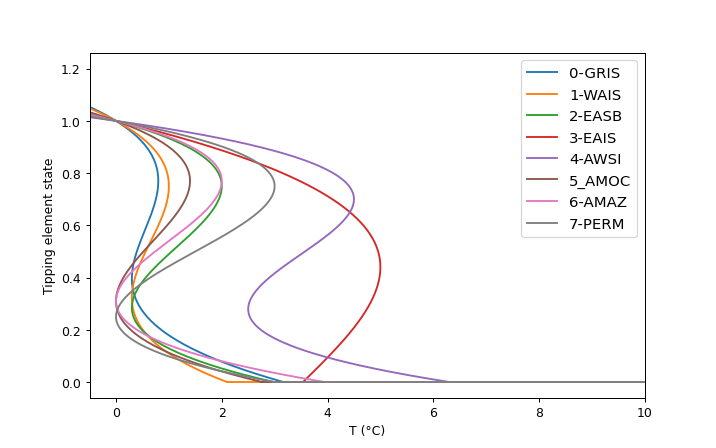

Text(0, 0.5, 'Tipping element state')

In [ ]:
A2 = np.array([a2_GRIS,a2_WAIS,a2_EASB,a2_EAIS,a2_AWSI,a2_AMOC,a2_AMAZ,a2_PERM])
A1 = np.array([a1_GRIS,a1_WAIS,a1_EASB,a1_EAIS,a1_AWSI,a1_AMOC,a1_AMAZ,a1_PERM])
C1 = np.array([c1_GRIS,c1_WAIS,c1_EASB,c1_EAIS,c1_AWSI,c1_AMOC,c1_AMAZ,c1_PERM])
C0 = np.array([c0_GRIS,c0_WAIS,c0_EASB,c0_EAIS,c0_AWSI,c0_AMOC,c0_AMAZ,c0_PERM])

labels = ['0-GRIS','1-WAIS','2-EASB','3-EAIS','4-AWSI','5_AMOC','6-AMAZ','7-PERM']
colors = ['C0','C1','C2','C3','C4','C5','C6','C7']

fig, ax = plt.subplots(1,1,figsize=(8,5))
    
for i in range(0,8):
    
    x = np.linspace(-0.8,1.2,1000)
    y = -1*(-x**3+A2[i]*x**2+A1[i]*x+C0[i])/C1[i]

    ax.plot(y[x>0],x[x>0],c=colors[i],label = labels[i])
    ax.plot([y[x>0][0],17],[0,0],c=colors[i])
    
ax.set_xlim((-0.5,10))
ax.legend(fontsize=12)

ax.set_xlabel('T (°C)')
ax.set_ylabel('Tipping element state')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/bifurcationdiags_worstcase.pdf")

In [ ]:
A2 = np.array([a2_GRIS,a2_WAIS,a2_EASB,a2_EAIS,a2_AWSI,a2_AMOC,a2_AMAZ,a2_PERM])
A1 = np.array([a1_GRIS,a1_WAIS,a1_EASB,a1_EAIS,a1_AWSI,a1_AMOC,a1_AMAZ,a1_PERM])
C1 = np.array([c1_GRIS,c1_WAIS,c1_EASB,c1_EAIS,c1_AWSI,c1_AMOC,c1_AMAZ,c1_PERM])
C0 = np.array([c0_GRIS,c0_WAIS,c0_EASB,c0_EAIS,c0_AWSI,c0_AMOC,c0_AMAZ,c0_PERM])
TAUP = np.array([taup_GRIS,taup_WAIS,taup_EASB,taup_EAIS,taup_AWSI,taup_AMOC,taup_AMAZ,taup_PERM])
TAUM = np.array([taum_GRIS,taum_WAIS,taum_EASB,taum_EAIS,taum_AWSI,taum_AMOC,taum_AMAZ,taum_PERM])

FMOD = np.array([fmod_GRIS,fmod_WAIS,fmod_EASB,fmod_EAIS,fmod_AWSI,fmod_AMOC,fmod_AMAZ,fmod_PERM])
CPOT = np.array([cpot_GRIS,cpot_WAIS,cpot_EASB,cpot_EAIS,cpot_AWSI,cpot_AMOC,cpot_AMAZ,cpot_PERM])
CH4POT = np.array([ch4pot_GRIS,ch4pot_WAIS,ch4pot_EASB,ch4pot_EAIS,ch4pot_AWSI,ch4pot_AMOC,ch4pot_AMAZ,ch4pot_PERM])


### Baseline

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1])
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(10,3),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol0 = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol0.t[time]+1750,sol0.y[9][time],c=targetColors[i],ls='-')
        
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))



ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top


#for axes in [ax1,ax2,ax3,ax4] : 
#    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
      
ax1.set_xticks([1750,1950,2100])
ax1.set_xticklabels(['1750','1950','2100'])
ax2.set_xticks([2300,5000,7500,10000])
ax2.set_xticklabels(['2300','5','7.5k','  10k'])
ax3.set_xticks([25000,50000,75000,100000])
ax3.set_xticklabels(['25k','50k','75k','  100k'])
ax4.set_xticks([250000,500000])
ax4.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'$\delta T_U$ (°C)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 


### With interaction

In [ ]:
Nexp = 15

sourceColors = ["#0077BB", "#CC3311",]
targetColors = colInterpolatOr(sourceColors, colorCode = "HEX", nTarget = Nexp)


t0=0 ; tend=500000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]

co2_landuse = zero_forcing(teval)
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

cfeedback = 1
d= 0.5
epsi = 1

solutions = []
    
for i in range(0,Nexp) : 
    
    co2_fossil = forcingCO2(2010,aa[i],mode='total',landuse= False, origin=1750) 
    sol = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')
    solutions.append(sol)
    print(aa[i], 'done')
    

1000.0 done
1285.7142857142858 done
1571.4285714285716 done
1857.142857142857 done
2142.857142857143 done
2428.5714285714284 done
2714.285714285714 done
3000.0 done
3285.714285714286 done
3571.4285714285716 done
3857.1428571428573 done
4142.857142857143 done
4428.571428571428 done
4714.285714285714 done
5000.0 done


<IPython.core.display.Javascript object>


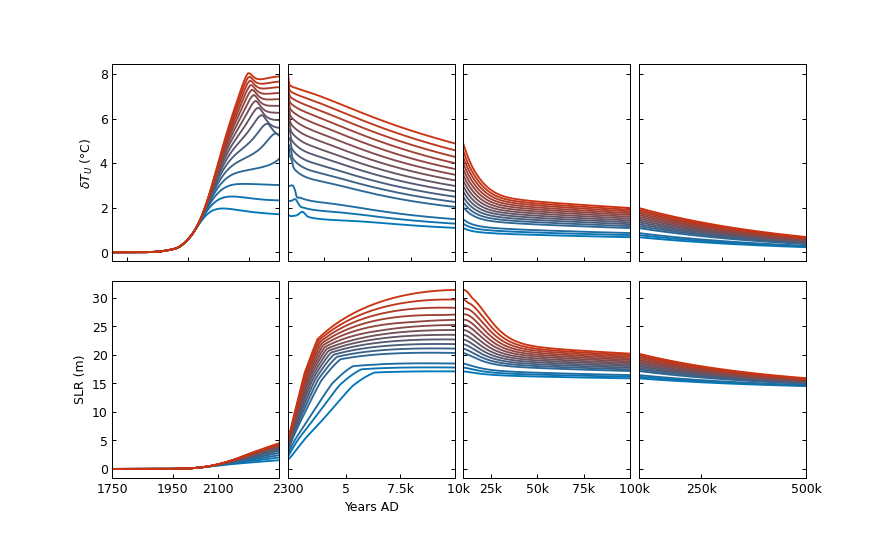

Text(0.5, 0, 'Years AD')

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4, figsize=(10,6),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,sol.y[9][time],c=targetColors[i])
    
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
            axes.plot(sol.t[time]+1750,SLR(sol)[time],c=targetColors[i],ls='-')
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
      
ax5.set_xticks([1750,1950,2100])
ax5.set_xticklabels(['1750','1950','2100'])
ax6.set_xticks([2300,5000,7500,10000])
ax6.set_xticklabels(['2300','5','7.5k','  10k'])
ax7.set_xticks([25000,50000,75000,100000])
ax7.set_xticklabels(['25k','50k','75k','  100k'])
ax8.set_xticks([250000,500000])
ax8.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'$\delta T_U$ (°C)')
ax5.set_ylabel(r'SLR (m)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 

ax6.set_xlabel('Years AD')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/worstcase_tempandslr.pdf")

<IPython.core.display.Javascript object>


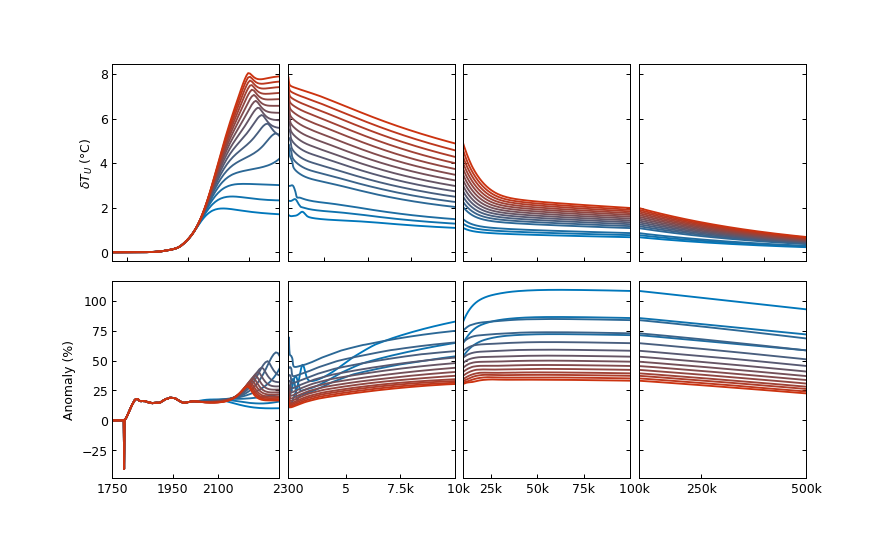

/tmp/ipykernel_111039/191691599.py:18: RuntimeWarning: invalid value encountered in divide
  axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time])/sol0.y[9][time]*100,c=targetColors[i])


In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4, figsize=(10,6),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions[i]
    sol0 = solutions_0[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,sol.y[9][time],c=targetColors[i])
             #axes.plot(sol0.t[time]+1750,sol0.y[9][time],c=targetColors[i],ls='--')
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
            axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time])/sol0.y[9][time]*100,c=targetColors[i])
          #  axes.plot(sol.t[time]+1750,(sol.y[9][time]-sol0.y[9][time]),c=targetColors[i])
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
      
ax5.set_xticks([1750,1950,2100])
ax5.set_xticklabels(['1750','1950','2100'])
ax6.set_xticks([2300,5000,7500,10000])
ax6.set_xticklabels(['2300','5','7.5k','  10k'])
ax7.set_xticks([25000,50000,75000,100000])
ax7.set_xticklabels(['25k','50k','75k','  100k'])
ax8.set_xticks([250000,500000])
ax8.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'$\delta T_U$ (°C)')
ax5.set_ylabel(r'Anomaly (%)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 


<IPython.core.display.Javascript object>


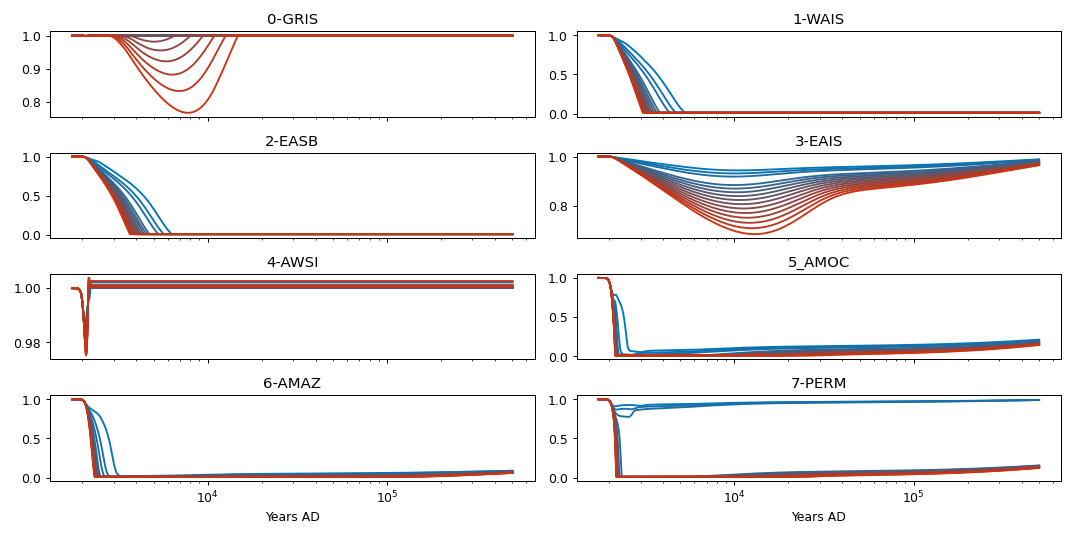

In [ ]:
fig,[[ax0,ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(12,6),sharex= True)

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
#     ax1.plot(sol.t[time]+1750,sol.y[0][time]/2.0724,c=targetColors[i])
#     ax2.plot(sol.t[time]+1750, sol.y[9][time],c=targetColors[i])
# #     ax3.plot(sol.t[time]+1750,SLR(sol),c=targetColors[i])
#     ax4.plot(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
#     ax5.plot(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
#     ax6.plot(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
#     ax7.plot(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    
    ax0.semilogx(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
    ax1.semilogx(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
    ax2.semilogx(sol.t[time]+1750, sol.y[17][time],c=targetColors[i])
    ax3.semilogx(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
    ax4.semilogx(sol.t[time]+1750, sol.y[19][time],c=targetColors[i])
    ax5.semilogx(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    ax6.semilogx(sol.t[time]+1750, sol.y[21][time],c=targetColors[i])
    ax7.semilogx(sol.t[time]+1750, sol.y[22][time],c=targetColors[i])

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]    

for i in range(0,8):
    axes[i].set_title(labels[i])
    
ax6.set_xlabel('Years AD')
ax7.set_xlabel('Years AD')
    
plt.tight_layout()

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/worstcase_TPs.pdf")

<IPython.core.display.Javascript object>


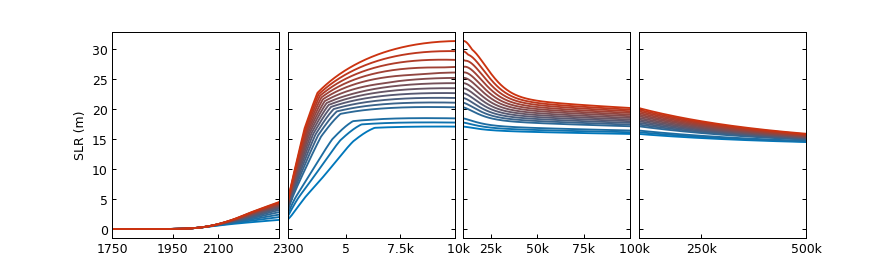

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1])
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(10,3),gridspec_kw=gs_kw)

time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
             axes.plot(sol.t[time]+1750,SLR(sol)[time],c=targetColors[i],ls='-')
        
                    
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))



ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top


#for axes in [ax1,ax2,ax3,ax4] : 
#    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)
      
ax1.set_xticks([1750,1950,2100])
ax1.set_xticklabels(['1750','1950','2100'])
ax2.set_xticks([2300,5000,7500,10000])
ax2.set_xticklabels(['2300','5','7.5k','  10k'])
ax3.set_xticks([25000,50000,75000,100000])
ax3.set_xticklabels(['25k','50k','75k','  100k'])
ax4.set_xticks([250000,500000])
ax4.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'SLR (m)')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 


<IPython.core.display.Javascript object>


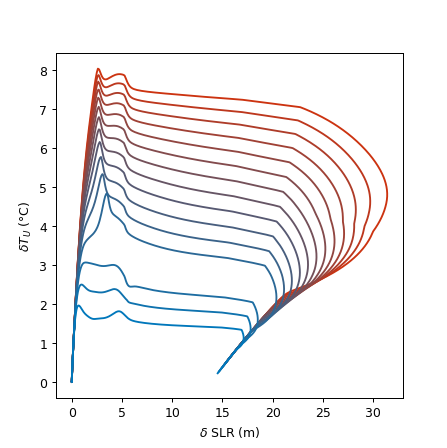

Text(0, 0.5, '$\\delta T_U$ (°C)')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

for i in range(0,Nexp) :
    sol = solutions[i]
    ax.plot(SLR(sol)[time],sol.y[9][time],c=targetColors[i],zorder = Nexp-i)

    
ax.set_xlabel(r'$\delta$ SLR (m)')
ax.set_ylabel(r'$\delta T_U$ (°C)')

In [ ]:
fig.savefig(r"/home/vcouplet/Desktop/THESE/figures/benasque_talk/worstcase_tempslr.pdf")

In [ ]:
Nexp = 15

sourceColors = ["#0077BB", "#CC3311",]
targetColors = colInterpolatOr(sourceColors, colorCode = "HEX", nTarget = Nexp)


t0=0 ; tend=500000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]

co2_landuse = zero_forcing(teval)
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

cfeedback = 1

d= 0.5
epsi = 1

aa = np.linspace(1000,5000,Nexp)
print(aa)

solutions = []

time = (np.rint(np.logspace(0,7,1000))).astype(int)-1

for i in range(0,Nexp) : 
    
    co2_fossil = forcingCO2(2010,aa[i],mode='total',landuse= False, origin=1750) 
    sol = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')
    solutions.append(sol)
    print(aa[i], 'done')
    

[1000.         1285.71428571 1571.42857143 1857.14285714 2142.85714286
 2428.57142857 2714.28571429 3000.         3285.71428571 3571.42857143
 3857.14285714 4142.85714286 4428.57142857 4714.28571429 5000.        ]
1000.0 done
1285.7142857142858 done
1571.4285714285716 done
1857.142857142857 done
2142.857142857143 done
2428.5714285714284 done
2714.285714285714 done
3000.0 done
3285.714285714286 done
3571.4285714285716 done
3857.1428571428573 done
4142.857142857143 done
4428.571428571428 done
4714.285714285714 done
5000.0 done


<IPython.core.display.Javascript object>


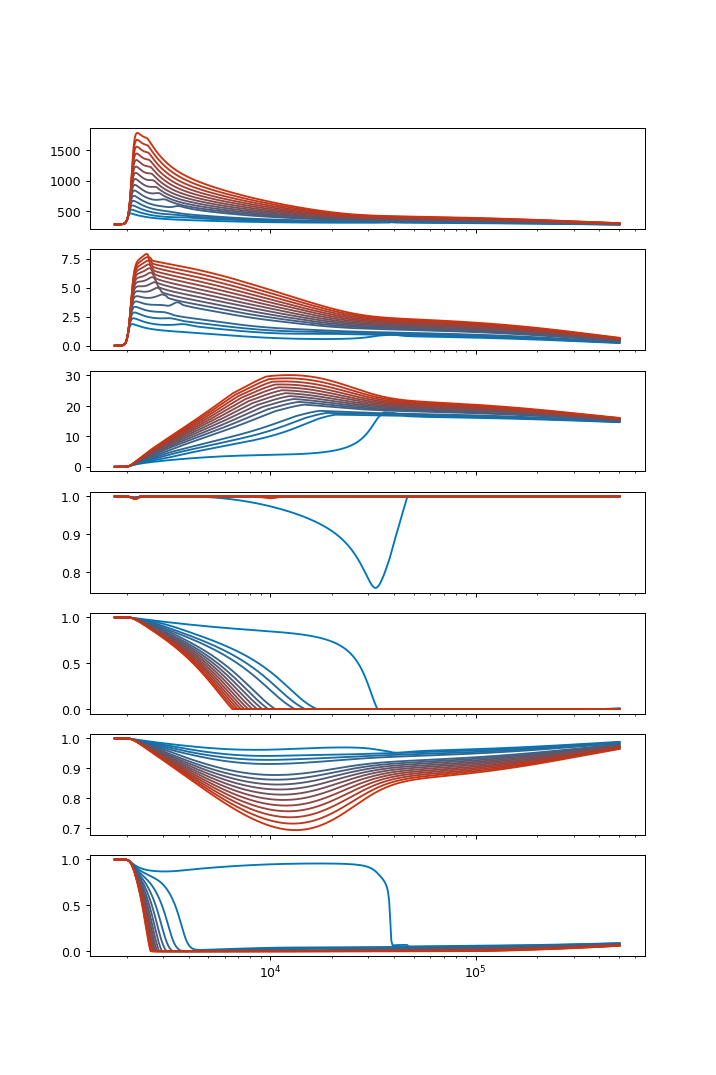

In [ ]:
time = (np.rint(np.logspace(0,6-np.log10(2),1000))).astype(int)-1
fig,[ax1,ax2,ax3,ax4,ax5,ax6,ax7] = plt.subplots(7,1,figsize=(8,12),sharex= True)

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
#     ax1.plot(sol.t[time]+1750,sol.y[0][time]/2.0724,c=targetColors[i])
#     ax2.plot(sol.t[time]+1750, sol.y[9][time],c=targetColors[i])
# #     ax3.plot(sol.t[time]+1750,SLR(sol),c=targetColors[i])
#     ax4.plot(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
#     ax5.plot(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
#     ax6.plot(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
#     ax7.plot(sol.t[time]+1750, sol.y[20][time],c=targetColors[i])
    
    ax1.semilogx(sol.t[time]+1750,sol.y[0][time]/2.0724,c=targetColors[i])
    ax2.semilogx(sol.t[time]+1750, sol.y[9][time],c=targetColors[i])
    ax3.semilogx(sol.t+1750,SLR(sol),c=targetColors[i])
    ax4.semilogx(sol.t[time]+1750, sol.y[15][time],c=targetColors[i])
    ax5.semilogx(sol.t[time]+1750, sol.y[16][time],c=targetColors[i])
    ax6.semilogx(sol.t[time]+1750, sol.y[18][time],c=targetColors[i])
    ax7.semilogx(sol.t[time]+1750, sol.y[21][time],c=targetColors[i])


<IPython.core.display.Javascript object>


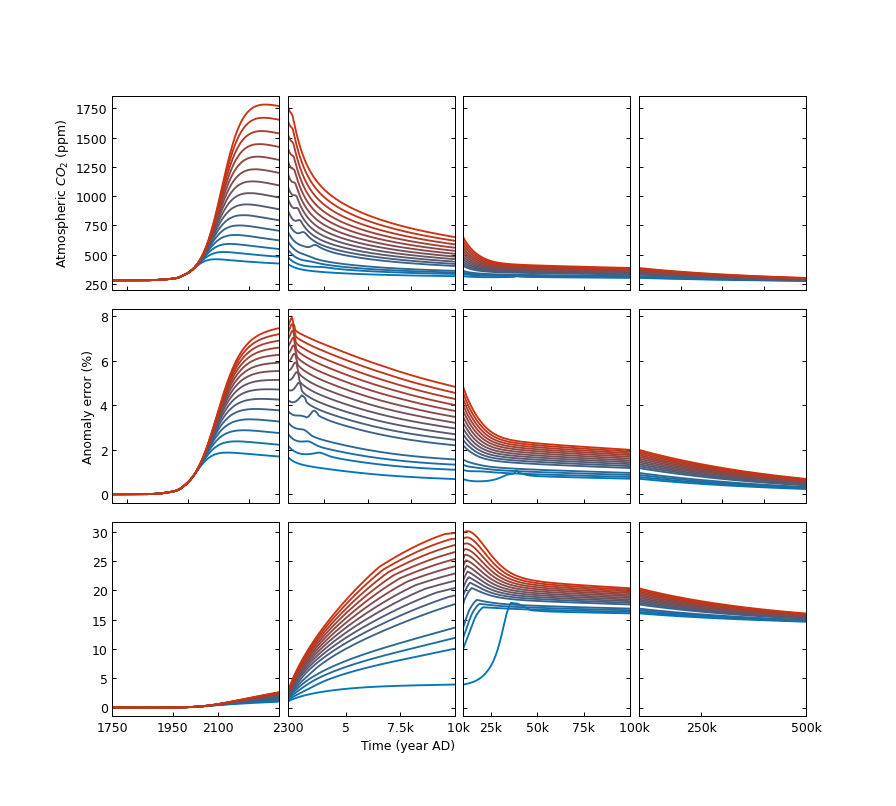

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12]] = plt.subplots(3,4, figsize=(10,9),gridspec_kw=gs_kw)

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
            axes.plot(sol.t[time]+1750,sol.y[0][time]/2.0724,c=targetColors[i])
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
            axes.plot(sol.t[time]+1750,sol.y[9][time],c=targetColors[i])
            
    for axes in [ax9,ax10,ax11,ax12] : 
        
            axes.plot(sol.t+1750,SLR(sol),c=targetColors[i])
           
        
        
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax9.set_xlim((1750,2300))
ax10.set_xlim((2300,10000))
ax11.set_xlim((10000,100000))
ax12.set_xlim((100000,500000))


ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax9.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8,ax10,ax11,ax12] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)



        
ax9.set_xticks([1750,1950,2100])
ax9.set_xticklabels(['1750','1950','2100'])
ax10.set_xticks([2300,5000,7500,10000])
ax10.set_xticklabels(['2300','5','7.5k','  10k'])
ax11.set_xticks([25000,50000,75000,100000])
ax11.set_xticklabels(['25k','50k','75k','  100k'])
ax12.set_xticks([250000,500000])
ax12.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'Atmospheric $CO_2$ (ppm)')
ax5.set_ylabel(r'Anomaly error (%)')

ax10.set_xlabel(r'    Time (year AD)',loc='right')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 


# Other tests

In [ ]:
A2 = np.array([a2_GRIS,a2_WAIS,a2_EASB,a2_EAIS,a2_AWSI,a2_AMOC,a2_AMAZ,a2_PERM])
A1 = np.array([a1_GRIS,a1_WAIS,a1_EASB,a1_EAIS,a1_AWSI,a1_AMOC,a1_AMAZ,a1_PERM])
C1 = np.array([c1_GRIS,c1_WAIS,c1_EASB,c1_EAIS,c1_AWSI,c1_AMOC,c1_AMAZ,c1_PERM])
C0 = np.array([c0_GRIS,c0_WAIS,c0_EASB,c0_EAIS,c0_AWSI,c0_AMOC,c0_AMAZ,c0_PERM])
TAUP = np.array([taup_GRIS,taup_WAIS,taup_EASB,taup_EAIS,taup_AWSI,taup_AMOC,taup_AMAZ,taup_PERM])
TAUM = np.array([taum_GRIS,taum_WAIS,taum_EASB,taum_EAIS,taum_AWSI,taum_AMOC,taum_AMAZ,taum_PERM])

FMOD = np.array([fmod_GRIS,fmod_WAIS,fmod_EASB,fmod_EAIS,fmod_AWSI,fmod_AMOC,fmod_AMAZ,fmod_PERM])
CPOT = np.array([cpot_GRIS,cpot_WAIS,cpot_EASB,cpot_EAIS,cpot_AWSI,cpot_AMOC,cpot_AMAZ,cpot_PERM])
CH4POT = np.array([ch4pot_GRIS,ch4pot_WAIS,ch4pot_EASB,ch4pot_EAIS,ch4pot_AWSI,ch4pot_AMOC,ch4pot_AMAZ,ch4pot_PERM])


t0=0 ; tend=50000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]

co2_landuse = zero_forcing(teval)
co2_fossil = forcingCO2(2010,3000,mode='total',landuse= False, origin=1750) 
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

cfeedback = 1
d = 0.5
epsi = 1
sol = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')


<IPython.core.display.Javascript object>


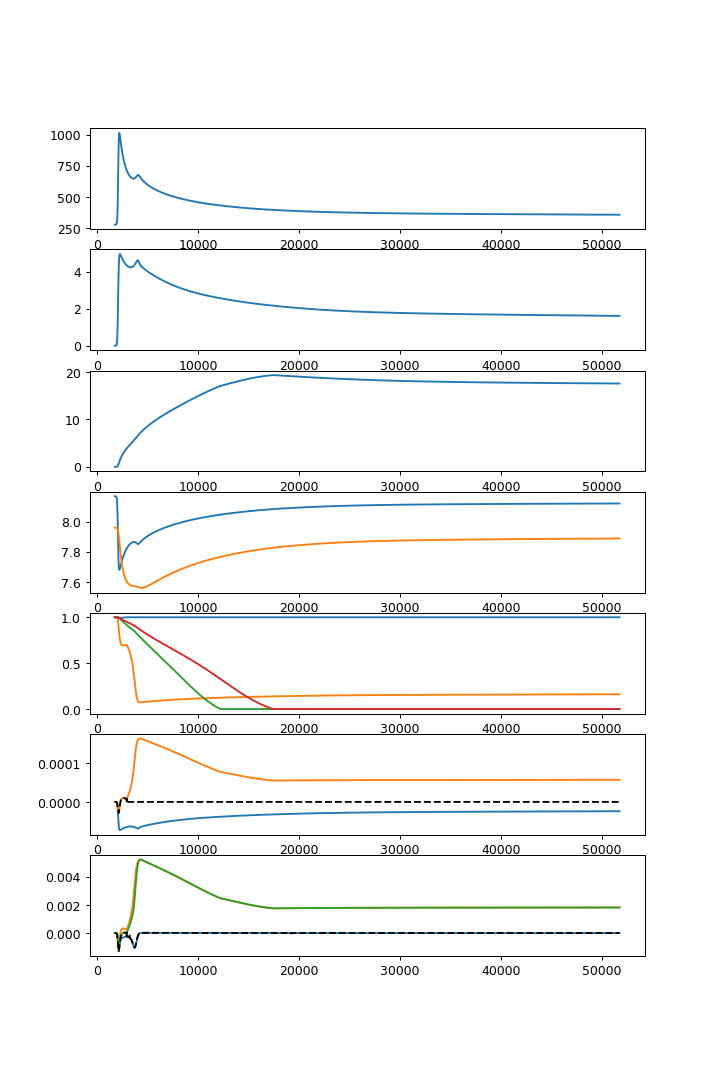

In [ ]:
fig,[ax1,ax2,ax3,ax4,ax5,ax6,ax7] = plt.subplots(7,1,figsize=(8,12))

solutions = [sol]
linestyles = ['-','--',':']

for j  in range(0,1) : 
    
    s= solutions[j]
    
    ax1.plot(s.t+1750,s.y[0]/2.0724,c='C0',ls=linestyles[j])
    ax2.plot(s.t+1750,s.y[9],c='C0',ls=linestyles[j])
    ax3.plot(s.t+1750,SLR(s),c='C0',ls=linestyles[j])
    
    HU,H2CO3U,HCO3U,CO3U = species(s,T_U,S_U, ktemp = True, level = 'U')
    HD,H2CO3D,HCO3D,CO3D = species(s,T_D,S_D, ktemp = True, level = 'D')
    
    ax4.plot(s.t+1750, -np.log10(HU),c='C0',ls=linestyles[j])
    ax4.plot(s.t+1750, -np.log10(HD),c='C1',ls=linestyles[j])
    
    ax5.plot(s.t+1750,s.y[15])
    ax5.plot(s.t+1750,s.y[20])
    ax5.plot(s.t+1750,s.y[16])
    ax5.plot(s.t+1750,s.y[17])
    
    HG_0= -s.y[15]**3+A2[0]*s.y[15]**2+A1[0]*s.y[15]+C1[0]*s.y[9]+C0[0]
    
    HG_c= -s.y[15]**3+A2[0]*s.y[15]**2+A1[0]*s.y[15]+C1[0]*s.y[9]+C0[0]-d*(S_moy[0,1]*(1-s.y[16])+S_moy[0,2]*(1-s.y[17])+S_moy[0,5]*(1-s.y[20]))
    

    
    ax6.plot(s.t+1750,HG_0/taum_GRIS)
    ax6.plot(s.t+1750,HG_c/taum_GRIS)
    ax6.plot(s.t[:-1]+1750,s.y[15,1:]-s.y[15,:-1],'k--')
    
    HAMOC_0 = -s.y[20]**3+A2[5]*s.y[20]**2+A1[5]*s.y[20]+C1[5]*s.y[9]+C0[5]-d*(S_moy[5,4]*(1-s.y[19]))
    HAMOC_c = HAMOC_0 + d*c_50*HG_c/taum_GRIS
    
    
    ax7.plot(s.t+1750,HAMOC_0/taum_AMOC)
    ax7.plot(s.t+1750,d*c_50*HG_c/taum_GRIS/taum_AMOC)
    ax7.plot(s.t+1750,HAMOC_c/taum_AMOC)
    ax7.plot(s.t[:-1]+1750,s.y[20,1:]-s.y[20,:-1],'k--')

<IPython.core.display.Javascript object>


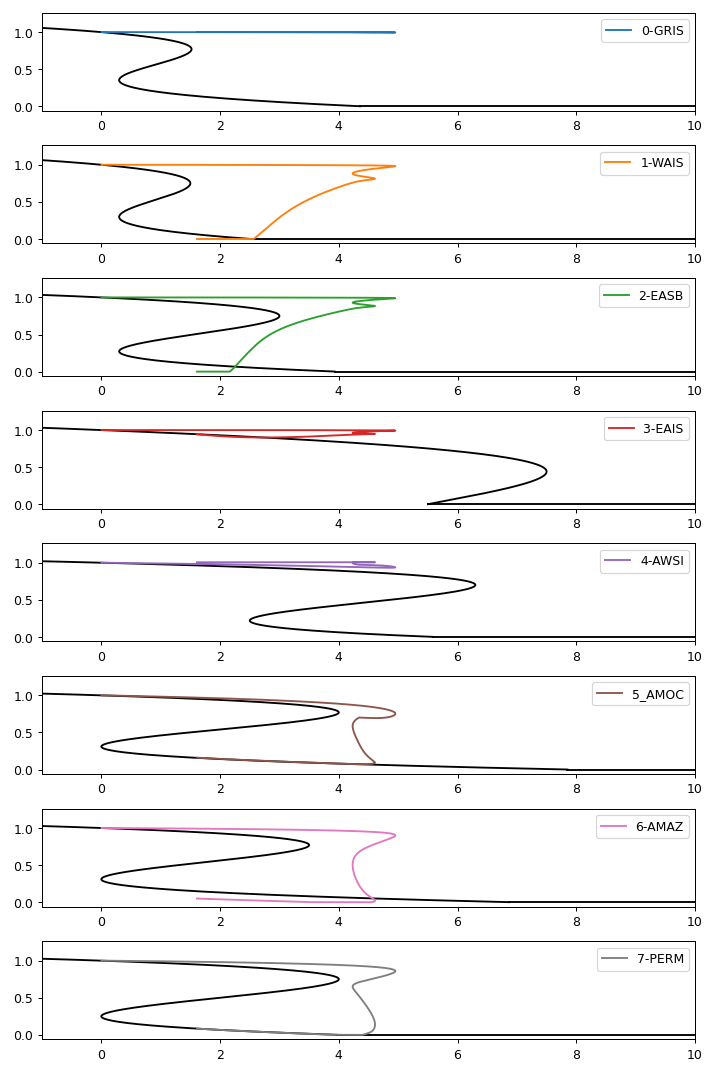

In [ ]:
fig,[ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7] = plt.subplots(8,1,figsize=(8,12))

ax_list = fig.axes
linestyles = ['-','--',':']

 
for i in range(0,8) :

    x = np.linspace(-0.8,1.2,1000)
    y = -1*(-x**3+A2[i]*x**2+A1[i]*x+C0[i])/C1[i]

    ax_list[i].plot(y[x>0],x[x>0],c='k')
    ax_list[i].plot([y[x>0][0],17],[0,0],c='k')
    
    for j in range(0,1):
    
        s = solutions[j]

        ax_list[i].plot(s.y[9],s.y[15+i], c= colors[i],label=labels[i],ls=linestyles[j])

    ax_list[i].set_xlim((-1,10))
    ax_list[i].legend()
    
plt.tight_layout()

In [ ]:
t0=0 ; tend=100000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]

co2_landuse = zero_forcing(teval)
co2_fossil = forcingCO2(2010,3000,mode='total',landuse= False, origin=1750) 
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

cfeedback = 0
d = 0
epsi = 0
sol = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')

cfeedback = 1
d = 0
epsi = 1
sol1 = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')

cfeedback = 0
d = 0.5
epsi = 0
sol2 = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')

cfeedback = 1
d = 0.5
epsi = 1
sol3 = SURFER_T(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')


<IPython.core.display.Javascript object>


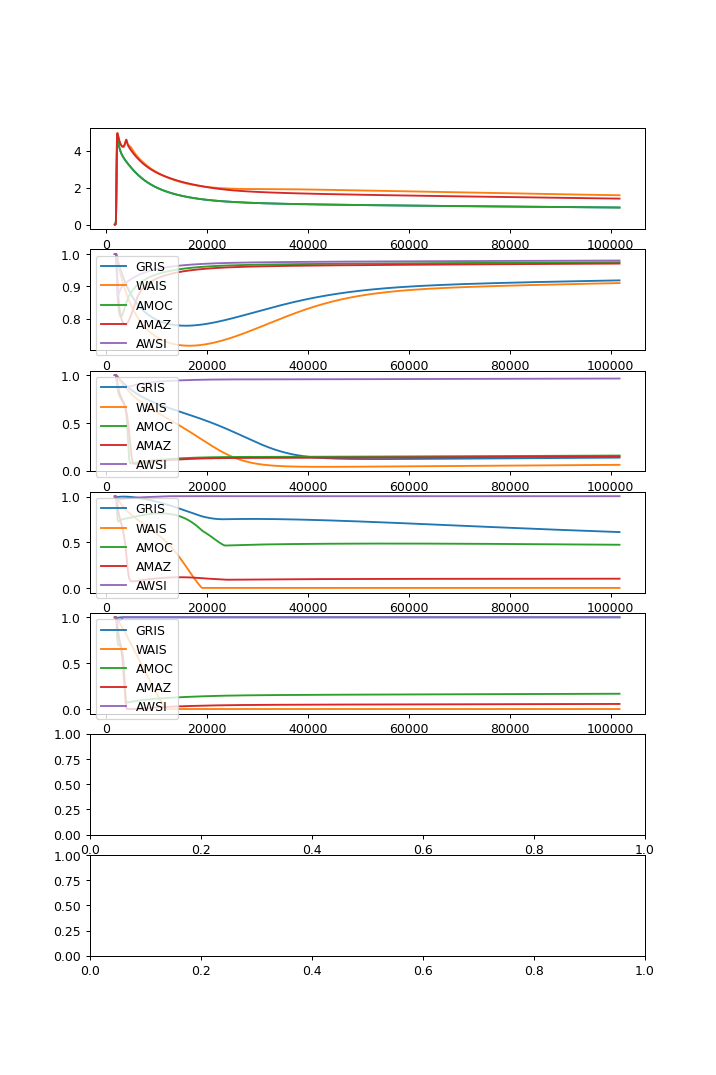

In [ ]:
fig,[ax1,ax2,ax3,ax4,ax5,ax6,ax7] = plt.subplots(7,1,figsize=(8,12))

solutions = [sol,sol1,sol2,sol3]

ax1.plot(sol.t+1750,sol.y[9])
ax1.plot(sol1.t+1750,sol1.y[9])
ax1.plot(sol2.t+1750,sol2.y[9])
ax1.plot(sol3.t+1750,sol3.y[9])



ax2.plot(sol.t+1750, sol.y[15],label ='GRIS')
ax2.plot(sol.t+1750, sol.y[16],label ='WAIS')
ax2.plot(sol.t+1750, sol.y[20],label ='AMOC')
ax2.plot(sol.t+1750, sol.y[21],label ='AMAZ')
ax2.plot(sol.t+1750, sol.y[19],label ='AWSI')
ax2.legend()

ax3.plot(sol1.t+1750, sol1.y[15],label ='GRIS')
ax3.plot(sol1.t+1750, sol1.y[16],label ='WAIS')
ax3.plot(sol1.t+1750, sol1.y[20],label ='AMOC')
ax3.plot(sol1.t+1750, sol1.y[21],label ='AMAZ')
ax3.plot(sol1.t+1750, sol1.y[19],label ='AWSI')
ax3.legend()

ax4.plot(sol2.t+1750, sol2.y[15],label ='GRIS')
ax4.plot(sol2.t+1750, sol2.y[16],label ='WAIS')
ax4.plot(sol2.t+1750, sol2.y[20],label ='AMOC')
ax4.plot(sol2.t+1750, sol2.y[21],label ='AMAZ')
ax4.plot(sol2.t+1750, sol2.y[19],label ='AWSI')
ax4.legend()

ax5.plot(sol3.t+1750, sol3.y[15],label ='GRIS')
ax5.plot(sol3.t+1750, sol3.y[16],label ='WAIS')
ax5.plot(sol3.t+1750, sol3.y[20],label ='AMOC')
ax5.plot(sol3.t+1750, sol3.y[21],label ='AMAZ')
ax5.plot(sol3.t+1750, sol3.y[19],label ='AWSI')
ax5.legend()

# for j  in range(0,1) : 
    
#     s= solutions[j]
    
#     ax1.plot(s.t+1750,s.y[0]/2.0724,c='C0',ls=linestyles[j])
#     ax2.plot(s.t+1750,s.y[9],c='C0',ls=linestyles[j])
#     ax3.plot(s.t+1750,SLR(s),c='C0',ls=linestyles[j])
    
#     HU,H2CO3U,HCO3U,CO3U = species(s,T_U,S_U, ktemp = True, level = 'U')
#     HD,H2CO3D,HCO3D,CO3D = species(s,T_D,S_D, ktemp = True, level = 'D')
    
#     ax4.plot(s.t+1750, -np.log10(HU),c='C0',ls=linestyles[j])
#     ax4.plot(s.t+1750, -np.log10(HD),c='C1',ls=linestyles[j])
    
#     ax5.plot(s.t+1750,s.y[15])
#     ax5.plot(s.t+1750,s.y[20])
#     ax5.plot(s.t+1750,s.y[16])
#     ax5.plot(s.t+1750,s.y[17])
    
#     HG_0= -s.y[15]**3+A2[0]*s.y[15]**2+A1[0]*s.y[15]+C1[0]*s.y[9]+C0[0]
    
#     HG_c= -s.y[15]**3+A2[0]*s.y[15]**2+A1[0]*s.y[15]+C1[0]*s.y[9]+C0[0]-d*(S_moy[0,1]*(1-s.y[16])+S_moy[0,2]*(1-s.y[17])+S_moy[0,5]*(1-s.y[20]))
    

    
#     ax6.plot(s.t+1750,HG_0/taum_GRIS)
#     ax6.plot(s.t+1750,HG_c/taum_GRIS)
#     ax6.plot(s.t[:-1]+1750,s.y[15,1:]-s.y[15,:-1],'k--')
    
#     HAMOC_0 = -s.y[20]**3+A2[5]*s.y[20]**2+A1[5]*s.y[20]+C1[5]*s.y[9]+C0[5]-d*(S_moy[5,4]*(1-s.y[19]))
#     HAMOC_c = HAMOC_0 + d*c_50*HG_c/taum_GRIS
    
    
#     ax7.plot(s.t+1750,HAMOC_0/taum_AMOC)
#     ax7.plot(s.t+1750,d*c_50*HG_c/taum_GRIS/taum_AMOC)
#     ax7.plot(s.t+1750,HAMOC_c/taum_AMOC)
#     ax7.plot(s.t[:-1]+1750,s.y[20,1:]-s.y[20,:-1],'k--')

<IPython.core.display.Javascript object>


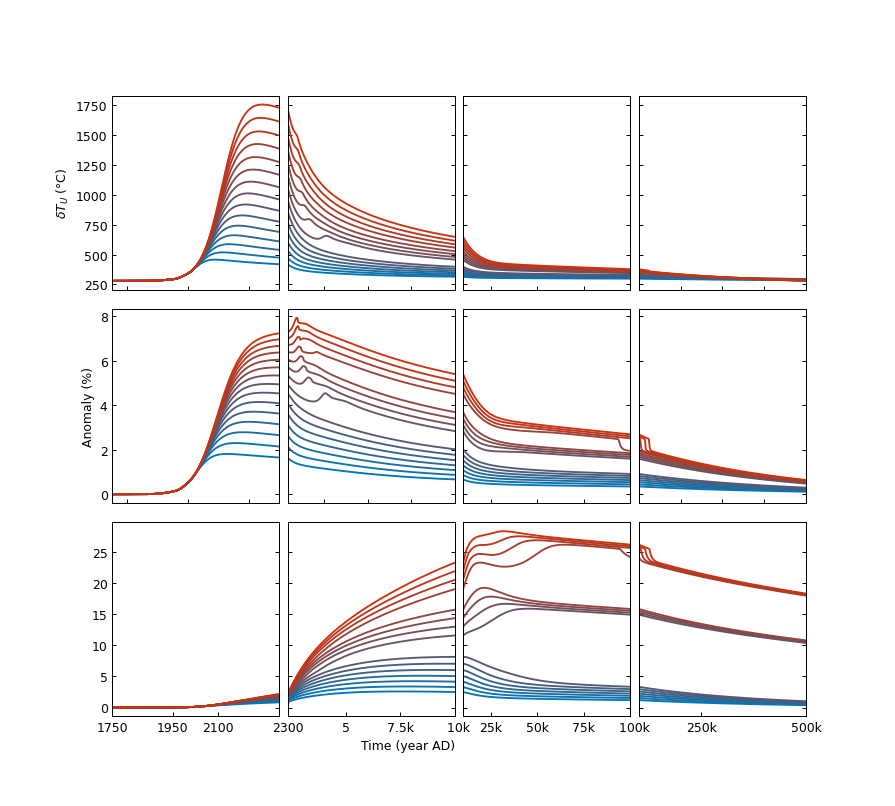

In [ ]:
gs_kw = dict(width_ratios=[1,1,1,1],height_ratios=[1,1,1])
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12]] = plt.subplots(3,4, figsize=(10,9),gridspec_kw=gs_kw)

for i in range(0,Nexp) :
    
    sol = solutions[i]
    
    for axes in [ax1,ax2,ax3,ax4] : 
        
            axes.plot(sol.t[time]+1750,sol.y[0][time]/2.0724,c=targetColors[i])
            
    for axes in [ax5,ax6,ax7,ax8] : 
        
            axes.plot(sol.t[time]+1750,sol.y[9][time],c=targetColors[i])
            
    for axes in [ax9,ax10,ax11,ax12] : 
        
            axes.plot(sol.t+1750,SLR(sol),c=targetColors[i])
           
        
        
ax1.set_xlim((1750,2300))
ax2.set_xlim((2300,10000))
ax3.set_xlim((10000,100000))
ax4.set_xlim((100000,500000))

ax5.set_xlim((1750,2300))
ax6.set_xlim((2300,10000))
ax7.set_xlim((10000,100000))
ax8.set_xlim((100000,500000))

ax9.set_xlim((1750,2300))
ax10.set_xlim((2300,10000))
ax11.set_xlim((10000,100000))
ax12.set_xlim((100000,500000))


ax1.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax5.tick_params(direction = 'in',right=True)# don't put tick labels at the top
ax9.tick_params(direction = 'in',right=True)# don't put tick labels at the top

for axes in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] : 
    axes.tick_params(labelbottom=False)
for axes in [ax2,ax3,ax4,ax6,ax7,ax8,ax10,ax11,ax12] : 
    axes.tick_params(direction = 'in',right = True)# don't put tick labels at the top
    axes.tick_params(labelleft=False)



        
ax9.set_xticks([1750,1950,2100])
ax9.set_xticklabels(['1750','1950','2100'])
ax10.set_xticks([2300,5000,7500,10000])
ax10.set_xticklabels(['2300','5','7.5k','  10k'])
ax11.set_xticks([25000,50000,75000,100000])
ax11.set_xticklabels(['25k','50k','75k','  100k'])
ax12.set_xticks([250000,500000])
ax12.set_xticklabels(['250k','500k'])

ax1.set_ylabel(r'$\delta T_U$ (°C)')
ax5.set_ylabel(r'Anomaly (%)')

ax10.set_xlabel(r'    Time (year AD)',loc='right')

fig.subplots_adjust(wspace=0.05) 
fig.subplots_adjust(hspace=0.1) 


<IPython.core.display.Javascript object>


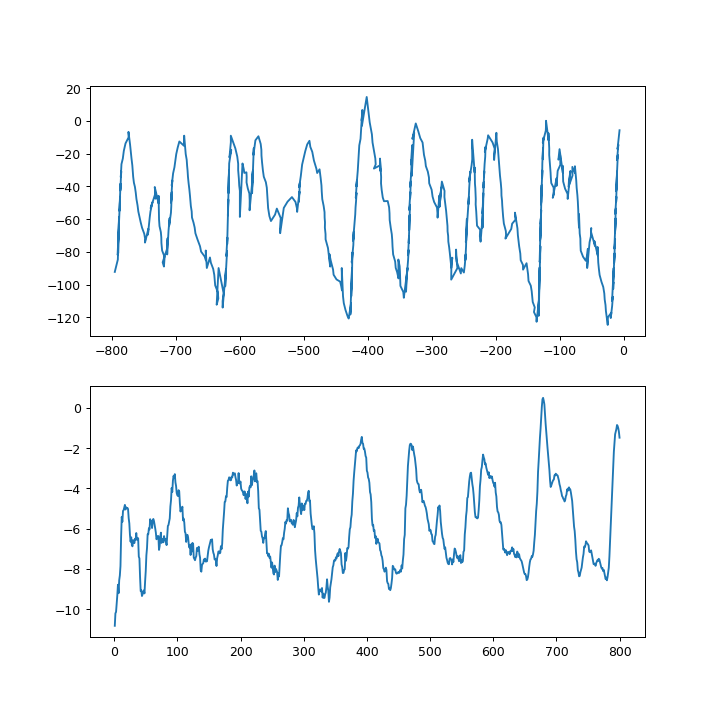

In [ ]:
slr = np.genfromtxt('SLR_800.csv', delimiter=',')
gst = np.genfromtxt('GST_snyder2016.csv', delimiter=',')

fig,[ax,ax2] = plt.subplots(2,1,figsize=(8,8))

ax.plot(slr[:,0],slr[:,1])
ax2.plot(gst[::-1,0],gst[:,1])

In [ ]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(8,8))

solutions = [sol,sol2,sol3]
linestyles = ['-','--',':']

for j  in range(0,3) : 
    
    s= solutions[j]
    
    ax1.plot(s.t,s.y[0]/2.0724,c='C0',ls=linestyles[j])
    ax2.plot(s.t,s.y[9],c='C0',ls=linestyles[j])
    ax3.plot(s.t,SLR(s),c='C0',ls=linestyles[j])
    
    HU,H2CO3U,HCO3U,CO3U = species(s,T_U,S_U, ktemp = True, level = 'U')
    HD,H2CO3D,HCO3D,CO3D = species(s,T_D,S_D, ktemp = True, level = 'D')
    
    ax4.plot(s.t, -np.log10(HU),c='C0',ls=linestyles[j])
    ax4.plot(s.t, -np.log10(HD),c='C1',ls=linestyles[j])
    

<IPython.core.display.Javascript object>


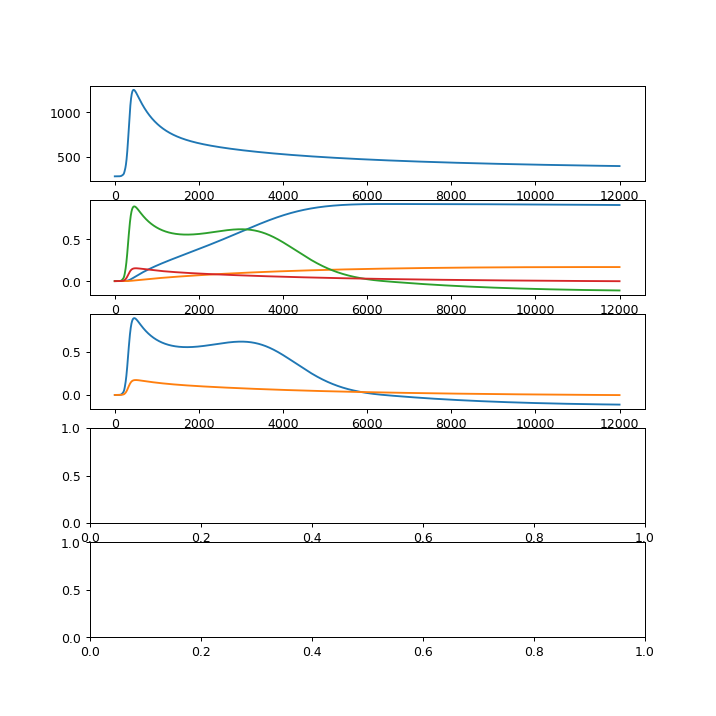

In [ ]:
fig,[ax1,ax2,ax3,ax4,ax5] = plt.subplots(5,1,figsize=(8,8))
 
ax1.plot(sol.t,sol.y[0]/2.0724)
ax2.plot(sol.t,1-sol.y[14])
ax2.plot(sol.t,1-sol.y[15])

HG= -sol.y[14]**3+A2[0]*sol.y[14]**2+A1[0]*sol.y[14]+C1[0]*sol.y[9]+C0[0]
HA= -sol.y[15]**3+A2[1]*sol.y[15]**2+A1[1]*sol.y[15]+C1[1]*sol.y[9]+C0[1]

ax3.plot(sol.t,-HG/taumG*7.2*11.47*35)
ax3.plot(sol.t,-HA/taumA*57*11.47*5)

ax2.plot(sol.t,-HG/taumG*2900)
ax2.plot(sol.t,-HA/taumA*2900)

## Offline tipping points model

We want to force the AMOC with the derivatives of the states of GRIS, WAIS, EASB instead of forcing with the states directly, as done in Wunderling et al (2021). Then we need to find new coefficients.

One solution is to add a multiplicative factor in front of the derivative in order to have similar values as for the state itself, then we can use the same coupling coefficients as in Wunderling. 

But we also want to incorporate some physics. We can first try to transform the derivative in our model into sverdups. The unit of our model is fractions of total mSLE. So if we multiply the derviate of our model by 
$$ SLE \times 1000 \times 361.80 $$ we obtain the ice loss in GigaTons(or equivalently km^3) of water per year. Then if we divide by 31536 be obtain the flux in sverdrups (10^6 m^3/s). Assembling the numbers, we can obtain the flux in sverdrups for the derivatives of GRIS, WAIS, EASB, EAIS by multiplying the derivative by the mSLE times 11.47 : 
$$ \frac{dx}{dt}\times SLE \times 11.47 $$

(See https://www.antarcticglaciers.org/glaciers-and-climate/estimating-glacier-contribution-to-sea-level-rise/)

But doing so for GRIS and for a 3000 PgC emiision scenario give use maximal fluxes of around 0.03 sverdrups. IN the naHOSMIP paper from Laura JAckson, they use hosings of 0.3 sv and 0.1 sv for a mor realisitc experiments, saying that this is already a high estimate, citing Sigebouw et al 2007. In that paper half the Greenlands (about 1 300 000 km3) melts in 500 yrs, meaning that about 2600 km3 melts every year leading to a mean meltwater flux of 0.08. In our experiment, halft the greenland melts in around 2000 years so we have about a quater of this flux, everything checks out. 

Still we have smaller values than the stte itself, so maybe we should still add a multiplicative factor. 

In [ ]:
# 0 - GRIS
# 1 - WAIS
# 2 - EASB
# 3 - EAIS
# 4 - AWSI
# 5 - AMOC
# 6 - AMAZ
# 7 - PERM

S_moy = np.zeros((8,8))

S_moy[0,1] = 1.5 # WAIS -> GRIS
S_moy[0,2] = 1.5 # EASB -> GRIS
S_moy[0,5] = -11/2 # AMOC -> GRIS

S_moy[1,0] = 11/2 # GRIS -> WAIS
S_moy[1,5] = 1.25 # AMOC -> WAIS

S_moy[2,0] = 11/2 # GRIS -> EASB
S_moy[2,5] = 1.25 # AMOC -> EASB

S_moy[4,5] = -1.5 # AMOC -> AWSI

S_moy[5,4] = 1.5 # AWSI -> AMOC

S_moy[6,5] = 0.5 # AMOC -> AMAZ

S_moy = S_moy/5

c_50 = (11/2)/5 # dGRIS -> AMOC
c_51 = 0 # dWAIS -> AMOC
c_52 = 0 # dEASB -> AMOC



Y = np.array([0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
COUPLING = S_moy@(1-Y[3:].T)

fmod_GRIS = 0.13
fmod_WAIS = 0.05
fmod_EASB = 0.05
fmod_EAIS = 0.60
fmod_AWSI = 0.60
fmod_AMOC = 0.00
fmod_AMAZ = 0.00
fmod_PERM = 0.00

print(S_moy)
print(COUPLING)

[[ 0.    0.3   0.3   0.    0.   -1.1   0.    0.  ]
 [ 1.1   0.    0.    0.    0.    0.25  0.    0.  ]
 [ 1.1   0.    0.    0.    0.    0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.3   0.    0.  ]
 [ 0.    0.    0.    0.    0.3   0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.1   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
[-0.25   0.675  0.675  0.    -0.15   0.15   0.05   0.   ]


In [ ]:
mA=1.727*10**20
mO=7.8*10**22
carbon_molar_mass=12*10**-3
water_molar_mass=18*10**-3
CO23_sat = 68.27

fco2 = 3.9
beta = 1.1143
gamma = 0.8357
cvol = 0.13

tau_ch4 = 9.5
ch4_pi = 720
co2_con_pi = 280


def TippingPoints_offline(co2_concentration,ch4_concentration,y0,t0,tend,dt):
    
    def f(t,y):
            
        co2_con = co2_concentration(t)
        ch4_con = ch4_concentration(t) 
        
        
        COUPLING = S_moy@(1-y[3:].T)
        H = -y[3:]**3+A2*y[3:]**2+A1*y[3:]+C1*y[0]-d*COUPLING+C0
        MU = H*0
        
        for i in range(0,len(y0)-3) :
            if H[i]>0 : 
                MU[i] = 1/TAUP[i]
            else :
                if y[3+i]> 0 :
                    MU[i] = 1/TAUM[i]
                else :
                    MU[i] = 0
                    
        ## add coupling for AMOC (need derivatives)
        
        H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
        
        if H[5]>0 : 
             MU[5] = 1/TAUP[5]
        else :
            if y[3+5]> 0 :
                MU[5] = 1/TAUM[5]
            else :
                MU[5] = 0
                
        dy = np.zeros(len(y0))
        
      
        dy[0] = (fco2*np.log2(co2_con/co2_con_pi)+0.036*(ch4_con**0.5-ch4_pi**0.5)-beta*y[0]+epsi*FMOD@(1-y[3:])-gamma*(y[0]-y[1]))/(cvol*hu)
        dy[1] = (gamma*(y[0]-y[1])-gamma*(y[1]-y[2]))/(cvol*hi)
        dy[2] = gamma*(y[1]-y[2])/(cvol*hd)

        
        dy[3:] = MU*H
        
        return dy

    
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

    sol=solve_ivp(f, [t0,tend], y0,method= 'LSODA',t_eval=teval,max_step = 10000)
    
    return sol

For a run
- Run normal SURFER with given emissions scenario
- Create CO2 and CH4 concentration scenarios from SURFER output
- Run offline tiping points model with these scenarios

In [ ]:
hu=150
hi=500
hd=2500

WU=mO*water_molar_mass*hu/(hu+hi+hd)
WI=mO*water_molar_mass*hi/(hu+hi+hd)
WD=mO*water_molar_mass*hd/(hu+hi+hd)

V = 0.065
F_CaCO3_pi = 0.065
F_CaSiO3_pi = 0.065
X = 1
F_LR = 0.5

K_AL = 0.025
beta_L=1.7
K_AU = 0.25
K_UI = 0.023*5
K_ID = 0.023*0.35
K_alk_UI = 0.021*5
K_alk_ID = 0.021*0.35

T_U = 273.15 + 17.4
S_U = 34.6
alk_U = 2215
pCO2_A = 280
DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A)

T_D = 273.15 + 1.73
S_D = 34.73
alk_D = 2336
CO32_D = 87
DIC_D = init_DICD(T_D,S_D,alk_D,CO32_D)

T_I = (T_U + T_D)/2
S_I = (S_U + S_D)/2 # not sure if this is valid
alk_I = (alk_U+alk_D)/2 # not sure if this is valid
DIC_I = (DIC_U + DIC_D)/2

MA_pi = 580.3
ML_pi = 2200
MU_pi = DIC_U*WU*carbon_molar_mass*10**-18
MI_pi = DIC_I*WI*carbon_molar_mass*10**-18
MD_pi = DIC_D*WD*carbon_molar_mass*10**-18
QU_pi = alk_U*WU*carbon_molar_mass*10**-18
QI_pi = alk_I*WI*carbon_molar_mass*10**-18
QD_pi = alk_D*WD*carbon_molar_mass*10**-18

ch4_pi = 720
Mch4_pi = ch4_pi*mA*carbon_molar_mass*10**-21

t0=0 ; tend=50000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi]

co2_landuse = zero_forcing(teval)
co2_fossil = forcingCO2(2010,3000,mode='total',landuse= False, origin=1750) 
ch4_landuse = zero_forcing(teval)
ch4_fossil = zero_forcing(teval)

sol0 = SURFER(co2_fossil,co2_landuse,ch4_fossil,ch4_landuse,y0,t0,tend,dt,ktemp = True,sediments = True ,weathering = True,atmtoland_flux='old', int_method = 'LSODA')

<IPython.core.display.Javascript object>


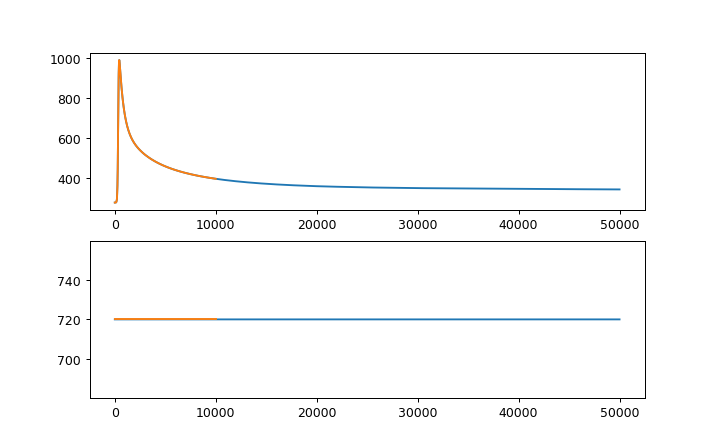

In [ ]:
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(8,5))

ax1.plot(sol0.t,sol0.y[0]/2.0724)
ax2.plot(sol0.t,sol0.y[12]/(mA*carbon_molar_mass)*10**21)

forcing_co2 = interpolate.interp1d(sol0.t,sol0.y[0]/2.0724,bounds_error= False, fill_value=280)
forcing_ch4 = interpolate.interp1d(sol0.t,sol0.y[12]/(mA*carbon_molar_mass)*10**21,bounds_error= False, fill_value=720)

time = np.linspace(0,10000,1000)

ax1.plot(time,forcing_co2(time))
ax2.plot(time,forcing_ch4(time))

In [ ]:
A2 = np.array([a2_GRIS,a2_WAIS,a2_EASB,a2_EAIS,a2_AWSI,a2_AMOC,a2_AMAZ,a2_PERM])
A1 = np.array([a1_GRIS,a1_WAIS,a1_EASB,a1_EAIS,a1_AWSI,a1_AMOC,a1_AMAZ,a1_PERM])
C1 = np.array([c1_GRIS,c1_WAIS,c1_EASB,c1_EAIS,c1_AWSI,c1_AMOC,c1_AMAZ,c1_PERM])
C0 = np.array([c0_GRIS,c0_WAIS,c0_EASB,c0_EAIS,c0_AWSI,c0_AMOC,c0_AMAZ,c0_PERM])
TAUP = np.array([taup_GRIS,taup_WAIS,taup_EASB,taup_EAIS,taup_AWSI,taup_AMOC,taup_AMAZ,taup_PERM])
TAUM = np.array([taum_GRIS,taum_WAIS,taum_EASB,taum_EAIS,taum_AWSI,taum_AMOC,taum_AMAZ,taum_PERM])
FMOD = np.array([fmod_GRIS,fmod_WAIS,fmod_EASB,fmod_EAIS,fmod_AWSI,fmod_AMOC,fmod_AMAZ,fmod_PERM])

d=1
epsi = 1

t0=0 ; tend=50000;dt=1
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
y0 = [0,0,0,1,1,1,1,1,1,1,1]


co2_concentration = forcing_co2
ch4_concentration = forcing_ch4

sol2 = TippingPoints_offline(co2_concentration,ch4_concentration,y0,t0,tend,dt)

<IPython.core.display.Javascript object>


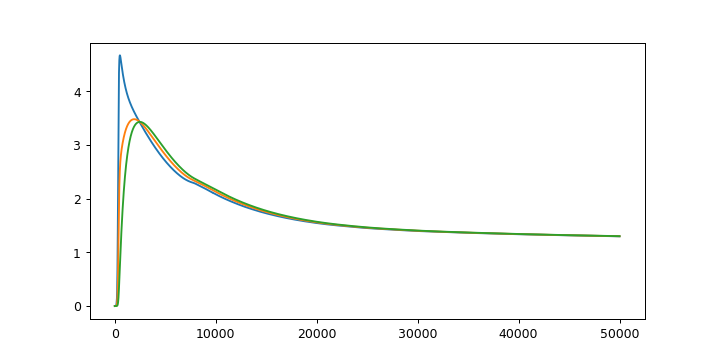

In [ ]:
fig,ax1 = plt.subplots(1,1,figsize=(8,4))

ax1.plot(sol2.t,sol2.y[0])
ax1.plot(sol2.t,sol2.y[1])
ax1.plot(sol2.t,sol2.y[2])


<IPython.core.display.Javascript object>


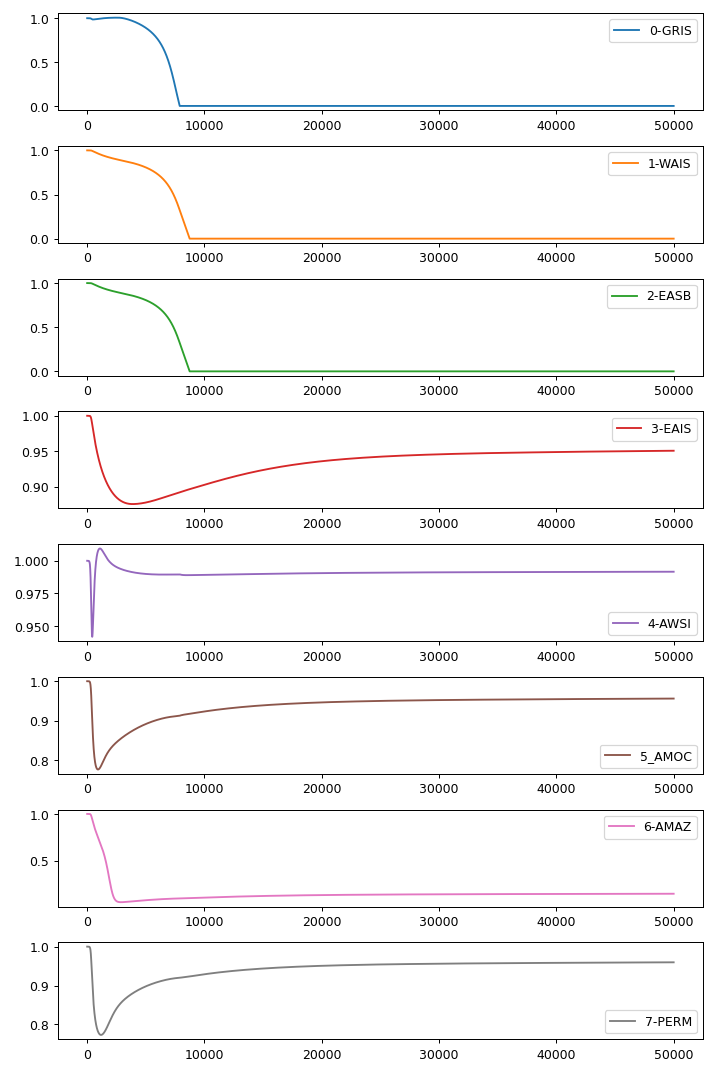

In [ ]:
fig,[ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7] = plt.subplots(8,1,figsize=(8,12))

ax_list = fig.axes

for i in range(0,8) :
    
    ax_list[i].plot(sol2.t,sol2.y[3+i], c= colors[i],label=labels[i])
#     ax_list[i].plot(sol.t,sol.y[14+i], c= colors[i],label=labels[i],ls='--')
        
#     ax_list[i].set_xlim((-1,7))
    ax_list[i].legend()
    
plt.tight_layout()

<IPython.core.display.Javascript object>


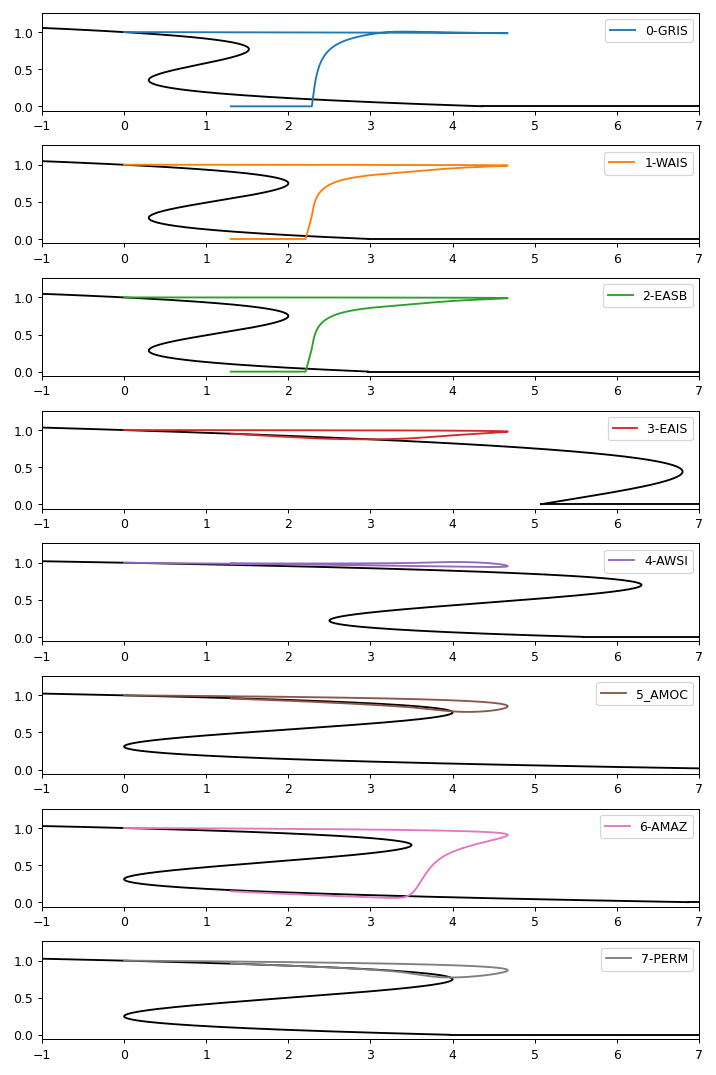

In [ ]:
fig,[ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7] = plt.subplots(8,1,figsize=(8,12))

ax_list = fig.axes

for i in range(0,8) :
   
    x = np.linspace(-0.8,1.2,1000)
    y = -1*(-x**3+A2[i]*x**2+A1[i]*x+C0[i])/C1[i]

    ax_list[i].plot(y[x>0],x[x>0],c='k')
    ax_list[i].plot([y[x>0][0],17],[0,0],c='k')
    
    ax_list[i].plot(sol2.y[0],sol2.y[3+i], c= colors[i],label=labels[i])
#     ax_list[i].plot(sol.y[9],sol.y[14+i], c= colors[i],label=labels[i],ls='--')
        
    ax_list[i].set_xlim((-1,7))
    ax_list[i].legend()
    
plt.tight_layout()

In [ ]:
from scipy.optimize import fsolve

# k=5
# lam=-1
# gamma=0.7
# hu=150
# hd=3000
# c2=0.13

# S=S_moy/10
# Tlim = np.array([[2],[3.15],[4.75],[4]])
# tau = np.array([[2000],[1000],[300],[50]])
# xi=0.5
# X=np.array([1,1,1,1])*xi
# d=0.5

FMOD = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
FMOD = np.array([fmod_GRIS,fmod_WAIS*10,fmod_EASB*10,fmod_EAIS,fmod_AWSI,fmod_AMOC,fmod_AMAZ,fmod_PERM])
print(np.sum(FMOD))

def equations(vars):
    
    DTu,DTi,DTd,x0,x1,x2,x3,x4,x5,x6,x7 = vars
    
    X = np.array([x0,x1,x2,x3,x4,x5,x6,x7])
        
    eq1 = fco2*np.log2(CO2/280)+0.036*(CH4**0.5-720**0.5)-beta*DTu-gamma*(DTu-DTi) + FMOD@(1-X)
    eq2 = gamma*(DTu-DTi)-gamma*(DTi-DTd)
    eq3 = gamma*(DTi-DTd)
    
   
    
    COUPLING = S_moy@(1-X.T)
    [eq4, eq5, eq6, eq7, eq8, eq9, eq10, eq11] = -X**3+A2*X**2+A1*X+C1*DTu-d*COUPLING+C0
   
    
    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9, eq10, eq11]


2.33


In [ ]:
CO2 = 400
CH4 =720
d=1

y0 = np.array([0,0,0,1,1,1,1,1,1,1,1])
sol, info, ier, msg =  fsolve(equations, y0, full_output=True)

In [ ]:
print(sol)
print(ier)
print(msg)

[1.80097368 1.80096429 1.80095976 1.11888583 1.09044538 1.09044538
 0.93030461 0.99003435 0.9341709  0.91305555 0.94107871]
5
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


In [ ]:
points=np.zeros(11)
Niter=3000
CO2 = 280
CH4 = 720
d=0

print((fco2*np.log2(CO2/280)+0.036*(CH4**0.5-720**0.5))/beta)
    
for i in range(0,Niter) :
    teq0 = (fco2*np.log2(CO2/280)+0.036*(CH4**0.5-720**0.5))/beta
    teq = np.random.uniform(teq0-0.2,teq0+1.43+0.2,1)
    y0=np.concatenate([teq,teq,teq,np.random.uniform(0,1,8)])

    sol, info, ier, msg =  fsolve(equations, y0, full_output=True)

    if ier == 1:

        points=np.vstack((points,sol))
    
print(points.shape)

W = np.unique(points[1:,:].round(decimals=6), axis=0)
print(W.shape)

0.0
(687, 11)
(384, 11)


In [ ]:
Cstep=0.1
numpoints = W.shape[0]
n=int((500-100)/Cstep)+1
CZ = np.empty((numpoints,n,11))
Z = np.empty((numpoints,n,11))
CZ[:] = np.nan
Z[:] = np.nan
carbon = np.linspace(100,500,n)

for i in range(0,numpoints):
    
    CO2 = 280
    ier = 1
    j = int((280-100)/Cstep)
    CZ[i,j,:] = CO2*np.ones(11)
    Z[i,j,:] = W[i,:]
    sol = W[i,:]
    
    while CO2<500 and ier ==1 :
        CO2=CO2+Cstep
        j=j+1
        y0 =sol
        sol, info, ier, msg =  fsolve(equations, y0, full_output=True)
        CZ[i,j,:] = CO2*np.ones(11)
        Z[i,j,:] = sol
        
    CO2 = 280
    ier = 1
    j = int((280-100)/Cstep)
    sol = W[i,:]
    
    while CO2>100 and ier ==1 :
        CO2=CO2-Cstep
        j=j-1
        y0 =sol
        sol, info, ier, msg =  fsolve(equations, y0, full_output=True)
        CZ[i,j,:] = CO2*np.ones(11)
        Z[i,j,:] = sol
    
    print(i,'done')

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done


KeyboardInterrupt: 

error: Result from function call is not a proper array of floats.

<IPython.core.display.Javascript object>


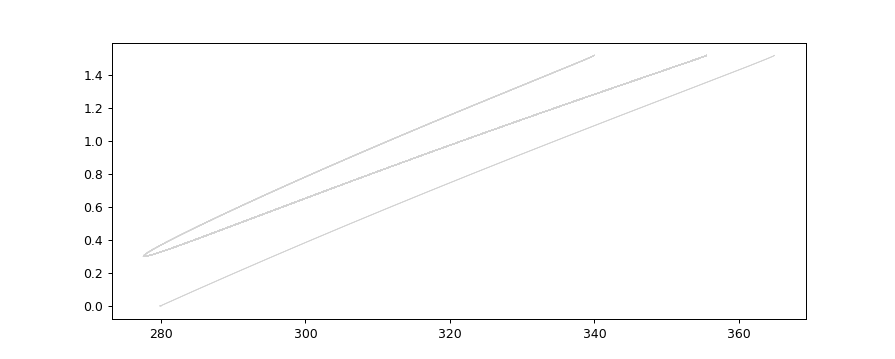

ValueError: array of sample points is empty

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,4))


for i in range(0,numpoints):
    ax.plot(CZ[i,:,0],Z[i,:,0],ls='-',c='lightgray',lw=0.6)
    
# bb = [0,13,14,15,32,33,34,42,43,46]

# for b in bb :

#    ax.plot(CZ[b,:,A+2],Z[b,:,A+2],'k')
    
# x1= np.linspace(-1.5,-1/(3**0.5),1000)
# x2= np.linspace(-1/(3**0.5),1/(3**0.5),1000)
# x3= np.linspace(1/(3**0.5),1.5,1000)
# y1=280*np.exp((-x1+x1**3)*Tlim[A]*(27/4)**0.5/5.35)
# y2=280*np.exp((-x2+x2**3)*Tlim[A]*(27/4)**0.5/5.35)
# y3=280*np.exp((-x3+x3**3)*Tlim[A]*(27/4)**0.5/5.35)

# ax.plot(y1,x1,'r')
# ax.plot(y2,x2,'r--')
# ax.plot(y3,x3,'r')

# ax.set_xlim((50,600))

# Na=20
# for i in range(0,Na) : 
#     a=aa[i]
# #     RCP = RCP_vec[i]
# #     co2_em = co2_em_vec[i]
# #     time = time_vec[i]
# #     rgba = cmap(a)

# #     RCP = RCP_vec2[i]
# #     co2_em = co2_em_vec2[i]
# #     time = time_vec2[i]
# #     rgba = cmap(a)
    
#     RCP = RCP_vec3[i]
#     co2_em = co2_em_vec3[i]
#     time = time_vec3[i]
#     rgba = cmap(a)
#     y0=np.array([0,0,-1,-1,-1,-1])
#     t0=0 ; tend=100000;dt=1   
#     sol= diffnetwork_forcing_do(S,Tlim,tau,d,k,RCP,y0,t0,tend,dt,X)
    

#     ax.plot(RCP(sol.t[:-1]),sol.y[0,:-1],color='cyan',zorder=12)

ax.set_xlabel(r'Atmospheric $CO_2$ (ppm)')
#ax.set_ylabel(r'Greenland Ice Sheet state')
ax.set_ylabel(r'$\Delta T$ (°C)')
ax.set_ylim((-6,6))
